In [426]:
import pandas as pd
import matplotlib as plt
%pylab inline
import category_encoders as ce
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/Users/wubing/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
listing = pd.read_csv("roofstock_marketplace_listing_historical_full.csv")
offer = pd.read_csv('roofstock_marketplace_offers_full.csv')
buyer = pd.read_csv('roofstock_marketplace_buyers_full.csv')
transaction = pd.read_csv('roofstock_marketplace_transactions_full.csv')

/Users/wubing/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (11,14,38,42,43,57,58,59,64,65,66,80,81,84,132,141,151,166,167,168,169,170) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
latter_final = pd.read_csv('/Users/wubing/Dropbox/RoofStock/latter_final.csv')

/Users/wubing/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (15,66,80,81,84,132,169) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Using zillow api to get external data

In [6]:
# read data with different listing IDs,  I will use these IDs to extract address information. And use address
# information to extract data from zillow
listing_zillow = pd.read_csv('/Users/wubing/Dropbox/RoofStock/zillow_listing.csv')

In [23]:
zillow = listing[listing['LISTING_ID'].isin(listing_zillow['LISTING_ID'])][['LISTING_ID','ADDRESS1', 'CITY', 'STATE', 'ZIP']]

In [24]:
zillow.head(10)

LISTING_ID          ADDRESS1      CITY STATE    ZIP
165     1625015  1359 Carr Cir NE  Palm Bay    FL  32905
166     1625015  1359 Carr Cir NE  Palm Bay    FL  32905
167     1625015  1359 Carr Cir NE  Palm Bay    FL  32905
168     1625015  1359 Carr Cir NE  Palm Bay    FL  32905
169     1625015  1359 Carr Cir NE  Palm Bay    FL  32905
170     1625015  1359 Carr Cir NE  Palm Bay    FL  32905
171     1625015  1359 Carr Cir NE  Palm Bay    FL  32905
172     1625015  1359 Carr Cir NE  Palm Bay    FL  32905
173     1625015  1359 Carr Cir NE  Palm Bay    FL  32905
174     1625015  1359 Carr Cir NE  Palm Bay    FL  32905

In [26]:
zillow.drop_duplicates(keep = 'last')

LISTING_ID               ADDRESS1          CITY STATE    ZIP
185        1625015       1359 Carr Cir NE      Palm Bay    FL  32905
207        1625016      1025 N Platte Way     Poinciana    FL  34759
332        1625021        1329 SE 12th St    Cape Coral    FL  33990
382        1625025       384 Jefferson St    Lake Wales    FL  33859
649        1625056       23194 Rye Avenue   Punta Gorda    FL  33980
...            ...                    ...           ...   ...    ...
288721     1742975         427 Hickory Ln    Plainfield    IN  46168
288729     1742977       333 Lullaby Blvd    Greenfield    IN  46140
288738     1742978         7006 E 13th St  Indianapolis    IN  46219
288746     1742985  5626 Massachusetts St  Merrillville    IN  46410
288758     1742986         1538 Porter St          Gary    IN  46406

[7446 rows x 5 columns]

In [30]:
new_zillow[new_zillow.duplicated(subset = ['LISTING_ID'])]

LISTING_ID                            ADDRESS1          CITY STATE  \
666        1625056                       23194 Rye Ave   Punta Gorda    FL   
2707       1625161  2593 Spring Lake Rd W (DUPLICATED)  Jacksonville    FL   
3596       1625204           120 Hemphill School Rd NW       Atlanta    GA   
7168       1625448             492 Waterwheel Falls Dr     Henderson    NV   
7196       1625450                 5187 Grape Leaf Ave     Las Vegas    NV   
...            ...                                 ...           ...   ...   
287272     1742620                606 E Oak St Apt # A         Wylie    TX   
287290     1742620                  606 E Oak St Apt A         Wylie    TX   
287911     1742756                     640 S Alpha Ave    Brownsburg    IN   
287932     1742759              12342 Van Spronsen Way     Oaklandon    IN   
288254     1742855                    1885 Richland Dr    Birmingham    AL   

          ZIP  
666     33980  
2707    32210  
3596    30331  
7168    89015  
7196    89141  
...       ...  
287272  75098  
287290  75098  
287911  46112  
287932  46236  
288254  35215  

[1284 rows x 5 columns]

In [52]:
new_zillow[new_zillow['LISTING_ID'] == 1742756]

LISTING_ID         ADDRESS1        CITY STATE    ZIP  zestimate
287903     1742756    640 Alpha Ave  Brownsburg    IN  46112        NaN
287911     1742756  640 S Alpha Ave  Brownsburg    IN  46112        NaN

In [38]:
new_zillow['ADDRESS1'].iloc[0] 

'1359 Carr Cir NE'

In [27]:
zillow = listing[listing['LISTING_ID'].isin(listing_zillow['LISTING_ID'])][['LISTING_ID','ADDRESS1', 'CITY', 'STATE', 'ZIP']]
new_zillow = zillow.drop_duplicates(keep = 'last')

In [40]:
# Go to zillow to register for new api key
key = "X1-ZW**************mj"

# create address and postal_code listing
address = []
postal_code = []
for i in tqdm(range(len(new_zillow))):
    address.append(str(new_zillow['ADDRESS1'].iloc[i] + ', '+ new_zillow['CITY'].iloc[i] + ', '+new_zillow['STATE'].iloc[i]))
    postal_code.append(new_zillow['ZIP'].iloc[i])

100%|██████████| 7446/7446 [00:00<00:00, 12753.04it/s]


In [42]:
import zillow
api = zillow.ValuationApi()
zestimate_value = []
for i in tqdm(range(len(address))):
    try:
        data = api.GetSearchResults(key, address[i], postal_code[i])
        zestimate_value.append(data.get_dict()['zestimate']['amount'])
    except:
        zestimate_value.append(np.nan)

100%|██████████| 7446/7446 [23:55<00:00,  5.19it/s]  


In [43]:
print(len(zestimate_value))
print(len(new_zillow))

7446
7446


In [44]:
new_zillow['zestimate'] = zestimate_value

/Users/wubing/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [121]:
new_zillow

LISTING_ID               ADDRESS1          CITY STATE    ZIP  \
185        1625015       1359 Carr Cir NE      Palm Bay    FL  32905   
207        1625016      1025 N Platte Way     Poinciana    FL  34759   
332        1625021        1329 SE 12th St    Cape Coral    FL  33990   
382        1625025       384 Jefferson St    Lake Wales    FL  33859   
649        1625056       23194 Rye Avenue   Punta Gorda    FL  33980   
...            ...                    ...           ...   ...    ...   
288721     1742975         427 Hickory Ln    Plainfield    IN  46168   
288729     1742977       333 Lullaby Blvd    Greenfield    IN  46140   
288738     1742978         7006 E 13th St  Indianapolis    IN  46219   
288746     1742985  5626 Massachusetts St  Merrillville    IN  46410   
288758     1742986         1538 Porter St          Gary    IN  46406   

        zestimate  
185      390467.0  
207      200589.0  
332      178538.0  
382      147231.0  
649      185867.0  
...           ...  
288721        NaN  
288729        NaN  
288738        NaN  
288746        NaN  
288758        NaN  

[7446 rows x 6 columns]

In [46]:
zestimate = new_zillow[new_zillow['LISTING_ID'].isin(listing_zillow['LISTING_ID'])][['zestimate']]

In [57]:
new_zillow['zestimate'].isnull().sum()

4576

In [70]:
new_zillow_dropdup = new_zillow.drop_duplicates(subset ="LISTING_ID", keep = 'last')

In [62]:
new_zillow_dropdup['zestimate'].isnull().sum()/len(new_zillow_dropdup['zestimate'])

0.5952612788055825

In [118]:
new_zillow_dropdup['zestimate'].isnull().sum()

3636

In [112]:
new_zillow_dropdup

LISTING_ID               ADDRESS1          CITY STATE    ZIP  \
185        1625015       1359 Carr Cir NE      Palm Bay    FL  32905   
207        1625016      1025 N Platte Way     Poinciana    FL  34759   
332        1625021        1329 SE 12th St    Cape Coral    FL  33990   
382        1625025       384 Jefferson St    Lake Wales    FL  33859   
666        1625056          23194 Rye Ave   Punta Gorda    FL  33980   
...            ...                    ...           ...   ...    ...   
288721     1742975         427 Hickory Ln    Plainfield    IN  46168   
288729     1742977       333 Lullaby Blvd    Greenfield    IN  46140   
288738     1742978         7006 E 13th St  Indianapolis    IN  46219   
288746     1742985  5626 Massachusetts St  Merrillville    IN  46410   
288758     1742986         1538 Porter St          Gary    IN  46406   

        zestimate  
185      390467.0  
207      200589.0  
332      178538.0  
382      147231.0  
666      185867.0  
...           ...  
288721        NaN  
288729        NaN  
288738        NaN  
288746        NaN  
288758        NaN  

[6162 rows x 6 columns]

In [113]:
new_zillow_dropdup.isnull().sum()

LISTING_ID       0
ADDRESS1         0
CITY             0
STATE            0
ZIP              0
zestimate     3636
dtype: int64

In [99]:
you_index=new_zillow_dropdup.dropna(subset=['zestimate']).index
zillow_with_na=new_zillow_dropdup.drop(you_index)

In [123]:
zillow_with_na.shape

(3636, 6)

In [106]:
len(zillow_with_na_1)

4920

In [117]:
zillow_with_na_1.head()

LISTING_ID                            ADDRESS1            CITY STATE  \
649      1625056                    23194 Rye Avenue     Punta Gorda    FL   
1313     1625091                    6127 Gillot Blvd  Port Charlotte    FL   
2687     1625161               2593 Spring Lake Rd W    Jacksonville    FL   
2707     1625161  2593 Spring Lake Rd W (DUPLICATED)    Jacksonville    FL   
3574     1625203                1102 Crystal Lake Rd         Atlanta    GA   

        ZIP  zestimate  
649   33980   185867.0  
1313  33981        NaN  
2687  32210   160790.0  
2707  32210        NaN  
3574  30349        NaN

In [136]:
len(zestimate_value)

4920

In [139]:
zillow_with_na_1['zestimate'] = zestimate_value

In [140]:
zillow_with_na_1['zestimate'].isnull().sum()

1294

Concat zillow_with_na_1 and new_zestimate

In [142]:
new_zillow['zestimate'].isnull().sum()

4576

In [146]:
for i in tqdm(range(len(new_zillow))):
    for j in range(len(zillow_with_na_1)):
        if new_zillow['LISTING_ID'].iloc[i] == zillow_with_na_1['LISTING_ID'].iloc[j]:
            new_zillow['zestimate'].iloc[i] = zillow_with_na_1['zestimate'].iloc[j]

  0%|          | 4/7446 [00:00<16:26,  7.55it/s]/Users/wubing/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/wubing/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
100%|██████████| 7446/7446 [15:20<00:00,  8.09it/s]


In [147]:
new_zillow['zestimate'].isnull().sum()

1165

In [148]:
len(new_zillow)

7446

In [149]:
new_zillow_dropdup = new_zillow.drop_duplicates(subset ="LISTING_ID", keep = 'last')

In [150]:
len(new_zillow_dropdup)

6162

In [151]:
new_zillow_dropdup.head()

LISTING_ID           ADDRESS1         CITY STATE    ZIP  zestimate
185     1625015   1359 Carr Cir NE     Palm Bay    FL  32905   390467.0
207     1625016  1025 N Platte Way    Poinciana    FL  34759   200589.0
332     1625021    1329 SE 12th St   Cape Coral    FL  33990   178538.0
382     1625025   384 Jefferson St   Lake Wales    FL  33859   147231.0
666     1625056      23194 Rye Ave  Punta Gorda    FL  33980   185867.0

In [153]:
zestimate_data = pd.DataFrame()
zestimate_data['LISTING_ID'] = new_zillow_dropdup['LISTING_ID']

In [154]:
zestimate_data['zestimate'] = new_zillow_dropdup['zestimate']

In [155]:
len(zestimate_data)

6162

# Impute missing value in zestimate

In [160]:
zestimate_data['zestimate'].isnull().sum()/len(zestimate_data['zestimate'])

0.13956507627393702

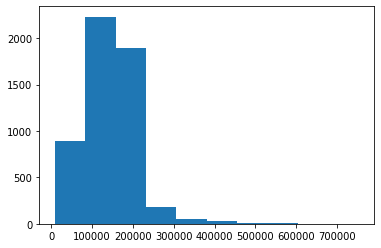

In [163]:
plt.hist(zestimate_data['zestimate']);

In [166]:
zestimate_data['zestimate'].median()

145340.5

In [214]:
zestimate_data = zestimate_data.fillna(145340.5)

In [216]:
zestimate_data['zestimate'].isnull().sum()/len(zestimate_data['zestimate'])

0.0

# k-means clustering

In [219]:
newdf=pd.read_csv('without_estimate.csv')
newdf['DISCOUNT']=newdf['OFFER_PRICE']/newdf['LIST_PRICE']
df_has_offer=newdf.drop(newdf[newdf['diff_days']==920].index)
zesti=pd.read_csv('zestimate_data.csv')
zesti_dic=zesti.set_index('LISTING_ID')['zestimate'].to_dict()
newdf['ZESTIMATE']=newdf['LISTING_ID'].map(lambda x: zesti_dic[x])
#newdf['ZESTIMATE_DISCOUNT']=newdf['LIST_PRICE']/newdf['ZESTIMATE']
newdf['ZESTIMATE_DIFFERENCE']=newdf['LIST_PRICE']-newdf['ZESTIMATE']

newdf['OFFER_OR_NOT']=newdf['diff_days'].map(lambda x: 1 if x!=920 else 0)
newdf['OFFER_OR_NOT']=newdf['OFFER_OR_NOT'].astype('category')

In [222]:
from sklearn.model_selection import train_test_split

In [223]:
dis_df=newdf.copy()
for u in dis_df.columns:
    if dis_df[u].dtype==bool:
        dis_df[u]=dis_df[u].astype('int')
dis_df.drop(['diff_days','EVENT_UTC','LISTING_ID','LISTING_INITIAL_PUBLISH_TS','DISCOUNT','OFFER_PRICE'],axis=1,inplace=True)
dis_df_X=dis_df.iloc[:,:-1]
dis_df_X=(dis_df_X-dis_df_X.mean())/dis_df_X.std()
dis_df_X=dis_df_X.fillna(0)
dis_X_train,dis_X_test,dis_y_train,dis_y_test=train_test_split(dis_df_X,dis_df['OFFER_OR_NOT'],test_size=0.2)

In [366]:
dis_df_X.head(5)

LISTING_STATUS_IS_ACTIVE   LOTSIZE  SQUAREFEET  BEDROOMS  BATHROOMS  \
0                  0.169173 -0.121701    0.588980  1.045449  -0.518393   
1                  0.169173 -0.106723    0.157340 -0.241094  -0.518393   
2                  0.169173 -0.106435    0.303860  1.045449   0.167287   
3                  0.169173 -0.040616   -0.206981  1.045449  -1.204073   
4                  0.169173 -0.142441    0.288020  1.045449  -0.518393   

     ISPOOL     ISHOA  GMAPHASSTREETVIEW  GMAPPOVHEADING  GMAPPOVPITCH  ...  \
0 -0.097598 -0.409484           1.037881        0.724671      0.724583  ...   
1 -0.097598 -0.409484           1.037881        0.763052      0.725214  ...   
2 -0.097598 -0.409484           1.037881        0.760966      0.725214  ...   
3 -0.097598 -0.409484           1.037881        0.781825      0.725004  ...   
4 -0.097598 -0.409484           1.037881        0.779739      0.725214  ...   

   STATE_OH  STATE_OK  STATE_PA  STATE_SC  STATE_TN  STATE_TX  STATE_WI  \
0  5.048501  -0.03565 -0.197954 -0.096537 -0.277843 -0.348248 -0.124646   
1  5.048501  -0.03565 -0.197954 -0.096537 -0.277843 -0.348248 -0.124646   
2  5.048501  -0.03565 -0.197954 -0.096537 -0.277843 -0.348248 -0.124646   
3 -0.198076  -0.03565 -0.197954 -0.096537 -0.277843 -0.348248 -0.124646   
4  5.048501  -0.03565 -0.197954 -0.096537 -0.277843 -0.348248 -0.124646   

   ZESTIMATE  ZESTIMATE_DIFFERENCE  OFFER_OR_NOT  
0  -0.686079              0.733606             0  
1  -0.500773              0.285064             0  
2  -0.307979              0.225389             0  
3  -1.321802              0.943072             0  
4   0.038717              0.172085             1  

[5 rows x 353 columns]

In [228]:
print(len(dis_df_X))
print(dis_df_X.shape)
print(len(dis_df['OFFER_OR_NOT']))

89025
(89025, 353)
89025


In [229]:
dis_df_X['OFFER_OR_NOT'] = dis_df['OFFER_OR_NOT']

In [230]:
print(dis_df_X.shape)

(89025, 354)


In [232]:
dis_df_X.head()

LISTING_STATUS_IS_ACTIVE   LOTSIZE  SQUAREFEET  BEDROOMS  BATHROOMS  \
0                  0.169173 -0.121701    0.588980  1.045449  -0.518393   
1                  0.169173 -0.106723    0.157340 -0.241094  -0.518393   
2                  0.169173 -0.106435    0.303860  1.045449   0.167287   
3                  0.169173 -0.040616   -0.206981  1.045449  -1.204073   
4                  0.169173 -0.142441    0.288020  1.045449  -0.518393   

     ISPOOL     ISHOA  GMAPHASSTREETVIEW  GMAPPOVHEADING  GMAPPOVPITCH  ...  \
0 -0.097598 -0.409484           1.037881        0.724671      0.724583  ...   
1 -0.097598 -0.409484           1.037881        0.763052      0.725214  ...   
2 -0.097598 -0.409484           1.037881        0.760966      0.725214  ...   
3 -0.097598 -0.409484           1.037881        0.781825      0.725004  ...   
4 -0.097598 -0.409484           1.037881        0.779739      0.725214  ...   

   STATE_OH  STATE_OK  STATE_PA  STATE_SC  STATE_TN  STATE_TX  STATE_WI  \
0  5.048501  -0.03565 -0.197954 -0.096537 -0.277843 -0.348248 -0.124646   
1  5.048501  -0.03565 -0.197954 -0.096537 -0.277843 -0.348248 -0.124646   
2  5.048501  -0.03565 -0.197954 -0.096537 -0.277843 -0.348248 -0.124646   
3 -0.198076  -0.03565 -0.197954 -0.096537 -0.277843 -0.348248 -0.124646   
4  5.048501  -0.03565 -0.197954 -0.096537 -0.277843 -0.348248 -0.124646   

   ZESTIMATE  ZESTIMATE_DIFFERENCE  OFFER_OR_NOT  
0  -0.686079              0.733606             0  
1  -0.500773              0.285064             0  
2  -0.307979              0.225389             0  
3  -1.321802              0.943072             0  
4   0.038717              0.172085             1  

[5 rows x 354 columns]

In [237]:
dis_df_X.drop(['PREVIOUSYEARLYPROPERTYTAXES'],axis=1,inplace=True)

In [240]:
dis_df_X.to_csv('clustring.csv', index = False)

In [243]:
dis_df_X.isnull().sum()

LISTING_STATUS_IS_ACTIVE    0
LOTSIZE                     0
SQUAREFEET                  0
BEDROOMS                    0
BATHROOMS                   0
                           ..
STATE_TX                    0
STATE_WI                    0
ZESTIMATE                   0
ZESTIMATE_DIFFERENCE        0
OFFER_OR_NOT                0
Length: 353, dtype: int64

In [244]:
%matplotlib inline
from copy import deepcopy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [245]:
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

In [247]:
from sklearn.cluster import KMeans

# Number of clusters
kmeans = KMeans(n_clusters=3)
# Fitting the input data
kmeans = kmeans.fit(dis_df_X)

In [248]:
centroids = kmeans.cluster_centers_
centroids

array([[-0.30970344, -0.03627078, -0.05105814, ..., -0.14847806,
        -0.00727982,  0.61469208],
       [ 0.16808418, -0.11231521, -0.0188522 , ..., -0.02176609,
        -0.18112487,  0.44566658],
       [ 0.16815291,  0.14336342,  0.07134631, ...,  0.17650604,
         0.17734893,  0.18569367]])

In [249]:
kmeans.score

<bound method KMeans.score of KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)>

In [253]:
kmeans.cluster_centers_

array([[-0.30970344, -0.03627078, -0.05105814, ..., -0.14847806,
        -0.00727982,  0.61469208],
       [ 0.16808418, -0.11231521, -0.0188522 , ..., -0.02176609,
        -0.18112487,  0.44566658],
       [ 0.16815291,  0.14336342,  0.07134631, ...,  0.17650604,
         0.17734893,  0.18569367]])

# buyer table EDA

In [254]:
buyer = pd.read_csv('/Users/wubing/Dropbox/RoofStock/roofstock_marketplace_buyers_full.csv')

In [255]:
buyer.head()

ACCOUNT_ID REGISTRATION_DATE  IS_SELF_REGISTERED_ACCT  IS_SELLER  \
0      189578         6/28/2019                     True      False   
1      128641         1/18/2018                     True      False   
2      138977          5/6/2018                     True      False   
3      196605          8/5/2019                     True      False   
4      201502         8/31/2019                     True      False   

         CITY STATE    ZIP        COUNTRY  ACCOUNT_OWNER_CONTACT_ID  \
0   Frederick    MD  21701            USA                       NaN   
1  Alpharetta    GA  30009            USA                       NaN   
2    Saratoga    CA  95070            USA                       NaN   
3    Kirkland    WA  98033            USA                       NaN   
4    Lakewood    CA  90713  UNITED STATES                    1104.0   

   ACCOUNT_TYPE_ROLE_ID  PROPERTIES_OWNED WEBSITE COUNTRY_OF_RESIDENCE  
0                   115               NaN     NaN                  NaN  
1                   115               NaN     NaN                  NaN  
2                   115               NaN     NaN                  NaN  
3                   115               NaN     NaN                  NaN  
4                   115               NaN     NaN                  NaN

In [260]:
buyer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1769 entries, 0 to 1768
Data columns (total 13 columns):
ACCOUNT_ID                  1769 non-null int64
REGISTRATION_DATE           1769 non-null datetime64[ns]
IS_SELF_REGISTERED_ACCT     1769 non-null bool
IS_SELLER                   1769 non-null bool
CITY                        1738 non-null object
STATE                       1735 non-null object
ZIP                         1738 non-null object
COUNTRY                     1554 non-null object
ACCOUNT_OWNER_CONTACT_ID    350 non-null float64
ACCOUNT_TYPE_ROLE_ID        1769 non-null int64
PROPERTIES_OWNED            156 non-null float64
WEBSITE                     2 non-null object
COUNTRY_OF_RESIDENCE        34 non-null object
dtypes: bool(2), datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 155.6+ KB


What can I find from buyer table?
- REGISTRATION_DATE. I have a trend for this one. But not very useful. But I can get how much time they will send out a offer
- 

In [261]:
offer = pd.read_csv('/Users/wubing/Dropbox/RoofStock/roofstock_marketplace_offers_full.csv')

In [286]:
offer_time = []
for i in tqdm(range(len(buyer[-200:-1]))):
    for j in range(len(offer)):
        if buyer['ACCOUNT_ID'].iloc[i] == offer['BUYER_ACCOUNT_ID'].iloc[j] & offer['OFFER_ITERATION_NUMBER'].iloc[j] == 1:
            offer_time.append(offer['EVENT_UTC'].iloc['j'])
        else:
            pass






  0%|          | 0/199 [00:00<?, ?it/s]




  1%|          | 1/199 [00:01<04:10,  1.27s/it]




  1%|          | 2/199 [00:02<04:00,  1.22s/it]




  2%|▏         | 3/199 [00:03<03:51,  1.18s/it]




  2%|▏         | 4/199 [00:04<03:44,  1.15s/it]




  3%|▎         | 5/199 [00:05<03:39,  1.13s/it]




  3%|▎         | 6/199 [00:06<03:36,  1.12s/it]




  4%|▎         | 7/199 [00:07<03:32,  1.10s/it]




  4%|▍         | 8/199 [00:08<03:28,  1.09s/it]




  5%|▍         | 9/199 [00:10<03:32,  1.12s/it]




  5%|▌         | 10/199 [00:11<04:12,  1.34s/it]




  6%|▌         | 11/199 [00:13<04:03,  1.29s/it]




  6%|▌         | 12/199 [00:15<05:02,  1.62s/it]




  7%|▋         | 13/199 [00:16<04:37,  1.49s/it]




  7%|▋         | 14/199 [00:18<04:32,  1.47s/it]




  8%|▊         | 15/199 [00:20<04:57,  1.62s/it]




  8%|▊         | 16/199 [00:24<07:30,  2.46s/it]




  9%|▊         | 17/199 [00:27<08:25,  2.78s/it]




  9%|▉         | 18/199 [00:29<07:05,  2.35s/it]




 10%|▉

In [339]:
account_id = buyer[buyer['ACCOUNT_ID'].isin(offer['BUYER_ACCOUNT_ID'])]['ACCOUNT_ID']

In [358]:
offer_time = []
for i in tqdm(range(len(account_id))):
    for j in range(len(offer)):
        if account_id.iloc[i] == offer['BUYER_ACCOUNT_ID'].loc[j] and offer['OFFER_ITERATION_NUMBER'].loc[j] == 1:
            offer_time.append(offer['EVENT_UTC'].loc[j])
            break
        else:
            pass









  0%|          | 0/1467 [00:00<?, ?it/s]







  0%|          | 1/1467 [00:00<20:34,  1.19it/s]







  0%|          | 2/1467 [00:01<16:21,  1.49it/s]







  0%|          | 3/1467 [00:01<13:53,  1.76it/s]







  0%|          | 5/1467 [00:02<12:56,  1.88it/s]







  1%|          | 8/1467 [00:04<13:18,  1.83it/s]







  1%|          | 9/1467 [00:04<11:08,  2.18it/s]







  1%|          | 10/1467 [00:05<16:51,  1.44it/s]







  1%|          | 11/1467 [00:06<16:04,  1.51it/s]







  1%|          | 12/1467 [00:07<20:57,  1.16it/s]







  1%|          | 13/1467 [00:09<26:56,  1.11s/it]







  1%|          | 14/1467 [00:10<25:34,  1.06s/it]







  1%|          | 16/1467 [00:10<20:17,  1.19it/s]







  1%|          | 18/1467 [00:11<15:14,  1.59it/s]







  1%|▏         | 20/1467 [00:11<12:15,  1.97it/s]







  1%|▏         | 21/1467 [00:12<12:30,  1.93it/s]







  2%|▏         | 23/1467 [00:12<09:06,  2.64it/s]







  2%|▏         | 24/1467 [00:12<08:55,

  9%|▉         | 132/1467 [01:03<06:47,  3.27it/s]







  9%|▉         | 133/1467 [01:04<11:50,  1.88it/s]







  9%|▉         | 134/1467 [01:04<11:59,  1.85it/s]







  9%|▉         | 135/1467 [01:05<11:18,  1.96it/s]







  9%|▉         | 136/1467 [01:05<12:09,  1.83it/s]







  9%|▉         | 137/1467 [01:05<09:22,  2.37it/s]







  9%|▉         | 138/1467 [01:06<07:51,  2.82it/s]







 10%|▉         | 140/1467 [01:06<05:49,  3.79it/s]







 10%|▉         | 141/1467 [01:07<10:52,  2.03it/s]







 10%|▉         | 142/1467 [01:07<09:30,  2.32it/s]







 10%|▉         | 143/1467 [01:07<07:22,  2.99it/s]







 10%|▉         | 144/1467 [01:07<06:27,  3.41it/s]







 10%|▉         | 146/1467 [01:08<05:29,  4.01it/s]







 10%|█         | 147/1467 [01:08<09:25,  2.33it/s]







 10%|█         | 148/1467 [01:09<11:52,  1.85it/s]







 10%|█         | 149/1467 [01:09<09:07,  2.41it/s]







 10%|█         | 150/1467 [01:10<07:07,  3.08it/s]







 10%|█        

 17%|█▋        | 253/1467 [01:56<08:26,  2.40it/s]







 17%|█▋        | 255/1467 [01:57<07:22,  2.74it/s]







 17%|█▋        | 256/1467 [01:57<07:44,  2.61it/s]







 18%|█▊        | 257/1467 [01:57<06:14,  3.23it/s]







 18%|█▊        | 259/1467 [01:58<08:02,  2.51it/s]







 18%|█▊        | 260/1467 [01:59<06:24,  3.14it/s]







 18%|█▊        | 261/1467 [01:59<06:14,  3.22it/s]







 18%|█▊        | 262/1467 [01:59<05:49,  3.44it/s]







 18%|█▊        | 263/1467 [01:59<05:57,  3.36it/s]







 18%|█▊        | 264/1467 [02:00<07:19,  2.74it/s]







 18%|█▊        | 266/1467 [02:00<05:35,  3.58it/s]







 18%|█▊        | 267/1467 [02:01<07:11,  2.78it/s]







 18%|█▊        | 268/1467 [02:05<33:34,  1.68s/it]







 18%|█▊        | 269/1467 [02:06<25:25,  1.27s/it]







 18%|█▊        | 270/1467 [02:08<31:31,  1.58s/it]







 18%|█▊        | 271/1467 [02:08<23:57,  1.20s/it]







 19%|█▊        | 272/1467 [02:10<25:15,  1.27s/it]







 19%|█▊       

 25%|██▌       | 371/1467 [03:33<13:32,  1.35it/s]







 25%|██▌       | 372/1467 [03:33<12:30,  1.46it/s]







 25%|██▌       | 373/1467 [03:33<09:24,  1.94it/s]







 25%|██▌       | 374/1467 [03:34<12:18,  1.48it/s]







 26%|██▌       | 375/1467 [03:35<09:52,  1.84it/s]







 26%|██▌       | 376/1467 [03:36<11:31,  1.58it/s]







 26%|██▌       | 377/1467 [03:36<10:42,  1.70it/s]







 26%|██▌       | 378/1467 [03:37<12:30,  1.45it/s]







 26%|██▌       | 380/1467 [03:37<09:12,  1.97it/s]







 26%|██▌       | 382/1467 [03:37<07:17,  2.48it/s]







 26%|██▌       | 383/1467 [03:38<08:59,  2.01it/s]







 26%|██▌       | 384/1467 [03:39<10:21,  1.74it/s]







 26%|██▌       | 385/1467 [03:39<08:51,  2.04it/s]







 26%|██▋       | 386/1467 [03:41<16:25,  1.10it/s]







 26%|██▋       | 387/1467 [03:44<29:41,  1.65s/it]







 26%|██▋       | 388/1467 [03:47<32:07,  1.79s/it]







 27%|██▋       | 389/1467 [03:48<32:51,  1.83s/it]







 27%|██▋      

 33%|███▎      | 488/1467 [04:35<13:51,  1.18it/s]







 33%|███▎      | 489/1467 [04:36<15:48,  1.03it/s]







 33%|███▎      | 490/1467 [04:37<12:08,  1.34it/s]







 33%|███▎      | 491/1467 [04:37<09:26,  1.72it/s]







 34%|███▎      | 492/1467 [04:38<11:02,  1.47it/s]







 34%|███▎      | 493/1467 [04:38<10:03,  1.62it/s]







 34%|███▎      | 494/1467 [04:39<12:02,  1.35it/s]







 34%|███▎      | 495/1467 [04:40<12:39,  1.28it/s]







 34%|███▍      | 496/1467 [04:41<14:28,  1.12it/s]







 34%|███▍      | 497/1467 [04:42<13:11,  1.23it/s]







 34%|███▍      | 498/1467 [04:42<10:00,  1.61it/s]







 34%|███▍      | 500/1467 [04:43<09:07,  1.77it/s]







 34%|███▍      | 501/1467 [04:44<09:20,  1.72it/s]







 34%|███▍      | 502/1467 [04:44<09:15,  1.74it/s]







 34%|███▍      | 504/1467 [04:45<07:44,  2.07it/s]







 34%|███▍      | 505/1467 [04:45<07:30,  2.14it/s]







 34%|███▍      | 506/1467 [04:46<08:11,  1.96it/s]







 35%|███▍     

 41%|████      | 605/1467 [05:28<06:12,  2.31it/s]







 41%|████▏     | 606/1467 [05:29<08:58,  1.60it/s]







 41%|████▏     | 607/1467 [05:29<06:53,  2.08it/s]







 42%|████▏     | 609/1467 [05:30<05:14,  2.73it/s]







 42%|████▏     | 610/1467 [05:30<04:28,  3.19it/s]







 42%|████▏     | 611/1467 [05:30<03:51,  3.70it/s]







 42%|████▏     | 612/1467 [05:31<05:31,  2.58it/s]







 42%|████▏     | 614/1467 [05:31<05:39,  2.51it/s]







 42%|████▏     | 616/1467 [05:32<04:33,  3.11it/s]







 42%|████▏     | 617/1467 [05:32<04:13,  3.35it/s]







 42%|████▏     | 619/1467 [05:33<04:53,  2.89it/s]







 42%|████▏     | 620/1467 [05:33<05:24,  2.61it/s]







 42%|████▏     | 622/1467 [05:34<05:46,  2.44it/s]







 42%|████▏     | 623/1467 [05:34<04:42,  2.99it/s]







 43%|████▎     | 624/1467 [05:35<05:18,  2.65it/s]







 43%|████▎     | 625/1467 [05:35<05:28,  2.57it/s]







 43%|████▎     | 626/1467 [05:36<04:41,  2.99it/s]







 43%|████▎    

 50%|████▉     | 728/1467 [06:18<04:11,  2.94it/s]







 50%|████▉     | 729/1467 [06:18<03:27,  3.56it/s]







 50%|████▉     | 730/1467 [06:18<02:51,  4.30it/s]







 50%|████▉     | 731/1467 [06:19<05:58,  2.05it/s]







 50%|████▉     | 733/1467 [06:19<04:24,  2.78it/s]







 50%|█████     | 734/1467 [06:20<06:33,  1.86it/s]







 50%|█████     | 735/1467 [06:21<05:08,  2.37it/s]







 50%|█████     | 736/1467 [06:21<07:00,  1.74it/s]







 50%|█████     | 738/1467 [06:22<05:48,  2.09it/s]







 50%|█████     | 740/1467 [06:22<04:29,  2.70it/s]







 51%|█████     | 741/1467 [06:23<04:13,  2.87it/s]







 51%|█████     | 742/1467 [06:23<03:48,  3.18it/s]







 51%|█████     | 743/1467 [06:24<05:40,  2.13it/s]







 51%|█████     | 744/1467 [06:24<06:37,  1.82it/s]







 51%|█████     | 745/1467 [06:25<06:25,  1.87it/s]







 51%|█████     | 746/1467 [06:26<07:45,  1.55it/s]







 51%|█████     | 747/1467 [06:26<06:57,  1.72it/s]







 51%|█████    

 58%|█████▊    | 847/1467 [07:07<04:33,  2.27it/s]







 58%|█████▊    | 848/1467 [07:08<05:56,  1.74it/s]







 58%|█████▊    | 849/1467 [07:09<04:33,  2.26it/s]







 58%|█████▊    | 850/1467 [07:09<03:56,  2.61it/s]







 58%|█████▊    | 851/1467 [07:09<03:27,  2.97it/s]







 58%|█████▊    | 852/1467 [07:09<02:55,  3.51it/s]







 58%|█████▊    | 853/1467 [07:10<03:31,  2.91it/s]







 58%|█████▊    | 854/1467 [07:10<03:42,  2.75it/s]







 58%|█████▊    | 855/1467 [07:10<03:34,  2.86it/s]







 58%|█████▊    | 856/1467 [07:11<03:19,  3.06it/s]







 58%|█████▊    | 857/1467 [07:11<02:54,  3.49it/s]







 58%|█████▊    | 858/1467 [07:12<04:58,  2.04it/s]







 59%|█████▊    | 859/1467 [07:13<05:59,  1.69it/s]







 59%|█████▊    | 860/1467 [07:13<04:34,  2.21it/s]







 59%|█████▉    | 862/1467 [07:13<03:37,  2.78it/s]







 59%|█████▉    | 863/1467 [07:14<05:06,  1.97it/s]







 59%|█████▉    | 865/1467 [07:14<04:09,  2.41it/s]







 59%|█████▉   

 66%|██████▌   | 962/1467 [07:55<03:28,  2.42it/s]







 66%|██████▌   | 963/1467 [07:56<04:43,  1.78it/s]







 66%|██████▌   | 964/1467 [07:57<04:30,  1.86it/s]







 66%|██████▌   | 965/1467 [07:57<03:36,  2.32it/s]







 66%|██████▌   | 966/1467 [07:57<02:53,  2.89it/s]







 66%|██████▌   | 967/1467 [07:58<04:42,  1.77it/s]







 66%|██████▌   | 968/1467 [07:58<03:38,  2.29it/s]







 66%|██████▌   | 969/1467 [07:59<03:40,  2.26it/s]







 66%|██████▌   | 970/1467 [07:59<04:27,  1.86it/s]







 66%|██████▌   | 971/1467 [08:00<04:10,  1.98it/s]







 66%|██████▋   | 972/1467 [08:00<03:43,  2.21it/s]







 66%|██████▋   | 973/1467 [08:01<04:13,  1.95it/s]







 66%|██████▋   | 974/1467 [08:01<03:59,  2.06it/s]







 66%|██████▋   | 975/1467 [08:02<04:40,  1.75it/s]







 67%|██████▋   | 976/1467 [08:03<04:40,  1.75it/s]







 67%|██████▋   | 977/1467 [08:03<03:33,  2.30it/s]







 67%|██████▋   | 978/1467 [08:03<03:16,  2.48it/s]







 67%|██████▋  

 81%|████████▏ | 1194/1467 [09:30<02:07,  2.14it/s]







 82%|████████▏ | 1196/1467 [09:31<02:01,  2.23it/s]







 82%|████████▏ | 1197/1467 [09:31<02:40,  1.68it/s]







 82%|████████▏ | 1198/1467 [09:32<02:19,  1.92it/s]







 82%|████████▏ | 1199/1467 [09:33<02:35,  1.72it/s]







 82%|████████▏ | 1200/1467 [09:33<02:11,  2.03it/s]







 82%|████████▏ | 1201/1467 [09:33<01:44,  2.55it/s]







 82%|████████▏ | 1202/1467 [09:33<01:21,  3.24it/s]







 82%|████████▏ | 1203/1467 [09:34<01:34,  2.78it/s]







 82%|████████▏ | 1204/1467 [09:34<02:01,  2.16it/s]







 82%|████████▏ | 1205/1467 [09:35<02:34,  1.70it/s]







 82%|████████▏ | 1206/1467 [09:35<01:59,  2.18it/s]







 82%|████████▏ | 1207/1467 [09:36<02:50,  1.53it/s]







 82%|████████▏ | 1208/1467 [09:37<02:25,  1.78it/s]







 82%|████████▏ | 1209/1467 [09:37<01:57,  2.19it/s]







 82%|████████▏ | 1210/1467 [09:37<01:31,  2.80it/s]







 83%|████████▎ | 1211/1467 [09:38<02:00,  2.12it/s]






 97%|█████████▋| 1421/1467 [11:16<00:25,  1.82it/s]







 97%|█████████▋| 1423/1467 [11:16<00:18,  2.35it/s]







 97%|█████████▋| 1424/1467 [11:16<00:14,  2.94it/s]







 97%|█████████▋| 1425/1467 [11:16<00:11,  3.61it/s]







 97%|█████████▋| 1426/1467 [11:17<00:21,  1.95it/s]







 97%|█████████▋| 1428/1467 [11:18<00:16,  2.37it/s]







 97%|█████████▋| 1429/1467 [11:19<00:20,  1.82it/s]







 97%|█████████▋| 1430/1467 [11:19<00:23,  1.59it/s]







 98%|█████████▊| 1431/1467 [11:20<00:25,  1.39it/s]







 98%|█████████▊| 1432/1467 [11:21<00:22,  1.58it/s]







 98%|█████████▊| 1433/1467 [11:22<00:21,  1.57it/s]







 98%|█████████▊| 1435/1467 [11:22<00:16,  1.88it/s]







 98%|█████████▊| 1436/1467 [11:23<00:19,  1.57it/s]







 98%|█████████▊| 1437/1467 [11:23<00:17,  1.69it/s]







 98%|█████████▊| 1438/1467 [11:24<00:14,  2.05it/s]







 98%|█████████▊| 1439/1467 [11:24<00:11,  2.44it/s]







 98%|█████████▊| 1440/1467 [11:24<00:09,  2.77it/s]






In [363]:
print(len(offer_time))
print(len(account_id))

1467
1467


In [369]:
account_id = pd.DataFrame(account_id)
account_id['offer_time'] = offer_time

In [380]:
account_id.head()
account_id['offer_time'].isnull().sum()

0

In [392]:
len(account_id['ACCOUNT_ID'].unique().tolist())

1467

In [378]:
print(len(buyer))
print(len(account_id))

1769
1467


In [393]:
offer_time = []
for i in tqdm(range(len(buyer))):
    for j in range(len(account_id)):
        if buyer['ACCOUNT_ID'].iloc[i] == account_id['ACCOUNT_ID'].iloc[j]:
            offer_time.append(account_id['offer_time'].iloc[j])
            break
        elif j == len(account_id)-1:
            offer_time.append(np.nan)
        else:
            pass










  0%|          | 0/1769 [00:00<?, ?it/s]








  1%|          | 12/1769 [00:00<00:17, 98.79it/s]








  1%|          | 15/1769 [00:00<00:30, 56.91it/s]








  1%|          | 21/1769 [00:00<00:34, 50.39it/s]








  2%|▏         | 29/1769 [00:00<00:33, 52.15it/s]








  2%|▏         | 35/1769 [00:00<00:35, 49.28it/s]








  2%|▏         | 42/1769 [00:00<00:34, 49.58it/s]








  3%|▎         | 47/1769 [00:00<00:39, 43.35it/s]








  3%|▎         | 55/1769 [00:01<00:38, 44.84it/s]








  3%|▎         | 61/1769 [00:01<00:42, 40.08it/s]








  4%|▎         | 65/1769 [00:01<00:56, 29.94it/s]








  4%|▍         | 75/1769 [00:01<00:47, 35.66it/s]








  5%|▍         | 84/1769 [00:01<00:42, 39.77it/s]








  5%|▌         | 95/1769 [00:01<00:36, 45.58it/s]








  6%|▌         | 104/1769 [00:02<00:31, 52.03it/s]








  6%|▋         | 111/1769 [00:02<00:34, 48.16it/s]








  7%|▋         | 118/1769 [00:02<00:33, 49.49it/s]








  8%|▊     

 61%|██████▏   | 1084/1769 [00:24<00:18, 36.57it/s]








 62%|██████▏   | 1088/1769 [00:24<00:18, 37.36it/s]








 62%|██████▏   | 1092/1769 [00:25<00:17, 37.89it/s]








 62%|██████▏   | 1096/1769 [00:25<00:18, 37.12it/s]








 62%|██████▏   | 1100/1769 [00:25<00:17, 37.90it/s]








 62%|██████▏   | 1104/1769 [00:25<00:18, 36.27it/s]








 63%|██████▎   | 1108/1769 [00:25<00:18, 36.19it/s]








 63%|██████▎   | 1113/1769 [00:25<00:17, 37.56it/s]








 63%|██████▎   | 1118/1769 [00:25<00:16, 38.39it/s]








 63%|██████▎   | 1122/1769 [00:25<00:17, 37.96it/s]








 64%|██████▎   | 1126/1769 [00:26<00:17, 37.68it/s]








 64%|██████▍   | 1130/1769 [00:26<00:16, 38.21it/s]








 64%|██████▍   | 1135/1769 [00:26<00:16, 38.99it/s]








 64%|██████▍   | 1139/1769 [00:26<00:16, 39.28it/s]








 65%|██████▍   | 1144/1769 [00:26<00:15, 39.61it/s]








 65%|██████▍   | 1148/1769 [00:26<00:15, 39.60it/s]








 65%|██████▌   | 1152/1769 [00:26<00:17,

 92%|█████████▏| 1628/1769 [00:49<00:08, 15.85it/s]








 92%|█████████▏| 1630/1769 [00:50<00:08, 15.54it/s]








 92%|█████████▏| 1632/1769 [00:50<00:08, 15.69it/s]








 92%|█████████▏| 1634/1769 [00:50<00:08, 15.78it/s]








 92%|█████████▏| 1636/1769 [00:50<00:08, 16.55it/s]








 93%|█████████▎| 1638/1769 [00:50<00:07, 16.68it/s]








 93%|█████████▎| 1640/1769 [00:50<00:07, 17.01it/s]








 93%|█████████▎| 1642/1769 [00:50<00:07, 17.57it/s]








 93%|█████████▎| 1644/1769 [00:50<00:07, 17.34it/s]








 93%|█████████▎| 1646/1769 [00:50<00:06, 17.85it/s]








 93%|█████████▎| 1648/1769 [00:51<00:06, 18.34it/s]








 93%|█████████▎| 1650/1769 [00:51<00:06, 17.59it/s]








 93%|█████████▎| 1652/1769 [00:51<00:07, 15.94it/s]








 93%|█████████▎| 1654/1769 [00:51<00:07, 15.75it/s]








 94%|█████████▎| 1656/1769 [00:51<00:06, 16.43it/s]








 94%|█████████▎| 1658/1769 [00:51<00:06, 16.74it/s]








 94%|█████████▍| 1661/1769 [00:51<00:06,

In [394]:
len(offer_time)

1769

In [403]:
pd.DataFrame(offer_time).isnull().sum()

0    302
dtype: int64

In [395]:
buyer['offer_time'] = offer_time

In [405]:
buyer[0:10]

ACCOUNT_ID REGISTRATION_DATE  IS_SELF_REGISTERED_ACCT  IS_SELLER  \
0      189578        2019-06-28                     True      False   
1      128641        2018-01-18                     True      False   
2      138977        2018-05-06                     True      False   
3      196605        2019-08-05                     True      False   
4      201502        2019-08-31                     True      False   
5      190370        2019-07-03                     True      False   
6      189177        2019-06-26                     True      False   
7      186317        2019-06-13                     True      False   
8      182004        2019-05-17                     True      False   
9      148558        2018-08-15                     True      False   

           CITY STATE     ZIP        COUNTRY  ACCOUNT_OWNER_CONTACT_ID  \
0     Frederick    MD   21701            USA                       NaN   
1    Alpharetta    GA   30009            USA                       NaN   
2      Saratoga    CA   95070            USA                       NaN   
3      Kirkland    WA   98033            USA                       NaN   
4      Lakewood    CA   90713  UNITED STATES                    1104.0   
5   Platteville    WI   53818            NaN                   29038.0   
6      Chuluota    FL  322766            USA                       NaN   
7        Irvine    CA   92604            USA                       NaN   
8      Chandler    AZ   85286            NaN                       NaN   
9  Newbury Park    CA   91320            USA                       NaN   

   ACCOUNT_TYPE_ROLE_ID  PROPERTIES_OWNED WEBSITE COUNTRY_OF_RESIDENCE  \
0                   115               NaN     NaN                  NaN   
1                   115               NaN     NaN                  NaN   
2                   115               NaN     NaN                  NaN   
3                   115               NaN     NaN                  NaN   
4                   115               NaN     NaN                  NaN   
5                   115               NaN     NaN                  NaN   
6                   115               NaN     NaN                  NaN   
7                   115               NaN     NaN                  NaN   
8                   115               NaN     NaN                  NaN   
9                   115               NaN     NaN                  NaN   

                      offer_time  
0  2019-07-31 23:04:40.799 +0000  
1  2018-07-31 18:06:36.039 +0000  
2  2018-05-16 18:42:40.689 +0000  
3                            NaN  
4                            NaN  
5  2019-07-15 21:01:44.029 +0000  
6  2019-07-02 21:33:55.902 +0000  
7  2019-06-19 08:02:37.065 +0000  
8  2019-05-29 04:06:36.059 +0000  
9  2019-02-20 08:12:52.165 +0000

In [410]:
print(type(buyer['REGISTRATION_DATE'].iloc[1]))
print(type(buyer['offer_time'].loc[1]))
print(buyer['offer_time'].loc[1] - buyer['REGISTRATION_DATE'].iloc[1])

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


TypeError: Timestamp subtraction must have the same timezones or no timezones

In [407]:
buyer['offer_time'] = pd.to_datetime(buyer['offer_time'])

In [416]:
buyer['offer_time'].loc[1].date() 

datetime.date(2018, 7, 31)

In [417]:
buyer['REGISTRATION_DATE'].iloc[1].date()

datetime.date(2018, 1, 18)

In [418]:
dates_diff = []
for i in tqdm(range(len(buyer))):
    dates_diff.append(buyer['offer_time'].loc[i].date() - buyer['REGISTRATION_DATE'].iloc[i].date())










  0%|          | 0/1769 [00:00<?, ?it/s]








100%|██████████| 1769/1769 [00:00<00:00, 9598.37it/s] 


In [421]:
dates_diff = pd.DataFrame(dates_diff)

In [441]:
dates_diff[0] = pd.to_numeric(dates_diff[0].dt.days, downcast='integer')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x101c7578d0>]],
      dtype=object)

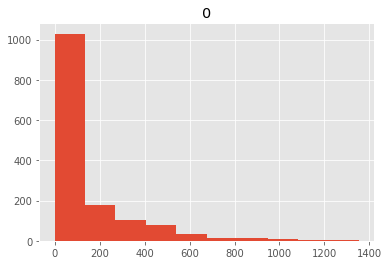

In [442]:

dates_diff.hist()

/Users/wubing/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/wubing/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


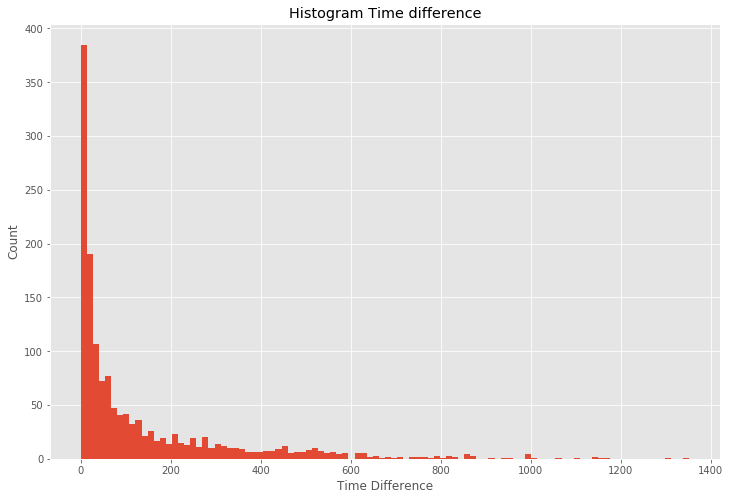

In [540]:
plt.figure(figsize=(12,8))
plt.xlabel('Time Difference')
plt.ylabel('Count')
plt.title('Histogram Time difference')
plt.hist(dates_diff[0], bins=100);

In [456]:
buyer.head()

ACCOUNT_ID REGISTRATION_DATE  IS_SELF_REGISTERED_ACCT  IS_SELLER  \
0      189578        2019-06-28                     True      False   
1      128641        2018-01-18                     True      False   
2      138977        2018-05-06                     True      False   
3      196605        2019-08-05                     True      False   
4      201502        2019-08-31                     True      False   

         CITY STATE    ZIP        COUNTRY  ACCOUNT_OWNER_CONTACT_ID  \
0   Frederick    MD  21701            USA                       NaN   
1  Alpharetta    GA  30009            USA                       NaN   
2    Saratoga    CA  95070            USA                       NaN   
3    Kirkland    WA  98033            USA                       NaN   
4    Lakewood    CA  90713  UNITED STATES                    1104.0   

   ACCOUNT_TYPE_ROLE_ID  PROPERTIES_OWNED WEBSITE COUNTRY_OF_RESIDENCE  \
0                   115               NaN     NaN                  NaN   
1                   115               NaN     NaN                  NaN   
2                   115               NaN     NaN                  NaN   
3                   115               NaN     NaN                  NaN   
4                   115               NaN     NaN                  NaN   

                        offer_time  
0 2019-07-31 23:04:40.799000+00:00  
1 2018-07-31 18:06:36.039000+00:00  
2 2018-05-16 18:42:40.689000+00:00  
3                              NaT  
4                              NaT

# Use offer table to see how much time to reply, get the time, get the distribution

In [469]:
offer[['LISTING_ID', 'OFFER_ID', 'EVENT_UTC', 'OFFER_DIRECTION', 'OFFER_ITERATION_NUMBER']]

LISTING_ID  OFFER_ID                      EVENT_UTC OFFER_DIRECTION  \
0         1720117   1063950  2019-06-05 15:32:05.665 +0000   BuyerToSeller   
1         1671539   1058402  2018-05-30 21:33:46.579 +0000   SellerToBuyer   
2         1671539   1058402  2018-06-01 22:00:17.576 +0000   SellerToBuyer   
3         1673141   1058872  2018-07-10 17:26:00.734 +0000   SellerToBuyer   
4         1627157   1055844  2017-07-05 23:08:16.050 +0000   BuyerToSeller   
...           ...       ...                            ...             ...   
31847     1679309   1059555  2018-08-24 21:09:25.591 +0000   BuyerToSeller   
31848     1700923   1061933  2019-03-24 16:11:44.528 +0000   SellerToBuyer   
31849     1710227   1064074  2019-06-09 06:05:23.466 +0000   SellerToBuyer   
31850     1684106   1060129  2018-10-16 20:59:30.803 +0000   BuyerToSeller   
31851     1684106   1060129  2018-10-19 16:54:06.328 +0000   SellerToBuyer   

       OFFER_ITERATION_NUMBER  
0                           5  
1                           8  
2                           9  
3                           2  
4                           1  
...                       ...  
31847                       2  
31848                       2  
31849                       6  
31850                       3  
31851                       4  

[31852 rows x 5 columns]

In [470]:
offer_id = offer['OFFER_ID']

In [476]:
type(offer['OFFER_ITERATION_NUMBER'].iloc[1])

numpy.int64

In [480]:
import datetime

In [498]:
reply_time_diff = []
for i in tqdm(offer_id):
    df = offer[offer['OFFER_ID'] == i]
    for j in range(len(df)):
        time1 = 0
        time2 = 0
        if df['OFFER_DIRECTION'].iloc[j] == 'SellerToBuyer':
            time1 = df['EVENT_UTC'].iloc[j]
            iteration = df['OFFER_ITERATION_NUMBER'].iloc[j]
            print(iteration)
            print(df['OFFER_DIRECTION'].iloc[j] + '    test')
            if df['OFFER_ITERATION_NUMBER'].iloc[j] == iteration - 1:
                print(df['OFFER_ITERATION_NUMBER'].iloc[j]+'test')
        #print(df['OFFER_DIRECTION'].iloc[j])
        '''
        
        if df['OFFER_DIRECTION'].iloc[j] == 'SellerToBuyer':
            time1 = df['EVENT_UTC'].iloc[j]
            #print(time1)
            iteration = df['OFFER_ITERATION_NUMBER'].iloc[j]
            if df['OFFER_ITERATION_NUMBER'].iloc[j] == iteration - 1:
                time2 = df['EVENT_UTC'].iloc[j]
                reply_time_diff.append(time1-time2)
        '''










  0%|          | 0/31852 [00:00<?, ?it/s]

10
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5










  0%|          | 45/31852 [00:00<01:10, 449.98it/s]








  0%|          | 82/31852 [00:00<01:15, 421.13it/s]


SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer  










  0%|          | 117/31852 [00:00<01:20, 395.21it/s]








  0%|          | 157/31852 [00:00<01:20, 393.48it/s]

9
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
3
SellerToBuyer    test
15
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerTo










  1%|          | 187/31852 [00:00<01:28, 359.71it/s]








  1%|          | 224/31852 [00:00<01:27, 361.03it/s]

16
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
Sell










  1%|          | 271/31852 [00:00<01:21, 387.84it/s]








  1%|          | 319/31852 [00:00<01:16, 410.02it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerTo










  1%|          | 359/31852 [00:00<01:17, 406.30it/s]


SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
17
SellerToBuyer    test
13
SellerToBuyer    test
19
SellerToBuyer    test
15
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
17
SellerToBuyer    test
13
SellerToBuyer    test
19
SellerToBuyer    test
15
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
17
SellerToBuyer    test
13
Se










  1%|▏         | 399/31852 [00:01<01:24, 370.46it/s]


SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test










  1%|▏         | 436/31852 [00:01<01:26, 362.57it/s]


6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerTo










  1%|▏         | 473/31852 [00:01<01:27, 358.17it/s]








  2%|▏         | 520/31852 [00:01<01:21, 384.86it/s]


SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBu










  2%|▏         | 567/31852 [00:01<01:17, 404.85it/s]








  2%|▏         | 609/31852 [00:01<01:18, 398.21it/s]

9
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
11
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerTo










  2%|▏         | 650/31852 [00:01<01:21, 384.55it/s]








  2%|▏         | 704/31852 [00:01<01:14, 420.80it/s]


SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
15
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
15
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
8
SellerT










  2%|▏         | 755/31852 [00:01<01:10, 442.38it/s]








  3%|▎         | 801/31852 [00:01<01:11, 436.74it/s]

2
SellerToBuyer    test
41
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
43
SellerToBuyer    test
47
SellerToBuyer    test
20
SellerToBuyer    test
34
SellerToBuyer    test
10
SellerToBuyer    test
32
SellerToBuyer    test
30
SellerToBuyer    test
16
SellerToBuyer    test
14
SellerToBuyer    test
26
SellerToBuyer    test
22
SellerToBuyer    test
37
SellerToBuyer    test
6
SellerToBuyer    test
29
SellerToBuyer    test
27
SellerToBuyer    test
18
SellerToBuyer    test
45
SellerToBuyer    test
8
SellerToBuyer    test
24
SellerToBuyer    test
39
SellerToBuyer    test
36
SellerToBuyer    test
49
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
18
SellerToBuyer    test
16
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuy










  3%|▎         | 846/31852 [00:02<01:15, 410.03it/s]








  3%|▎         | 888/31852 [00:02<01:15, 411.87it/s]

7
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuye










  3%|▎         | 930/31852 [00:02<01:20, 385.42it/s]








  3%|▎         | 970/31852 [00:02<01:23, 372.04it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuye










  3%|▎         | 1008/31852 [00:02<01:24, 363.33it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
14
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
5
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
21
SellerToBuyer    test
17
SellerToBuyer    test
15
SellerToBuyer    test
25
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
28
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
19
SellerToBuyer    test
23
SellerToBuyer    test
8
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
5
S










  3%|▎         | 1066/31852 [00:02<01:15, 407.25it/s]

4
SellerToBuyer    test
8
SellerToBuyer    test
14
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
17
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test











  3%|▎         | 1110/31852 [00:02<01:13, 415.54it/s]

4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
13
SellerToBuyer    test
22
SellerToBuyer    test
19
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
23
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
13
SellerToBuyer    test
22
SellerToBuyer    test
19
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
23
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test










  4%|▎         | 1155/31852 [00:02<01:12, 425.08it/s]


SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2










  4%|▍         | 1199/31852 [00:02<01:13, 417.74it/s]


SellerToBuyer    test
7
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
7
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
Sell










  4%|▍         | 1242/31852 [00:03<01:14, 411.93it/s]








  4%|▍         | 1284/31852 [00:03<01:28, 347.10it/s]


SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuy










  4%|▍         | 1321/31852 [00:03<01:32, 329.13it/s]

12
SellerToBuyer    test
18
SellerToBuyer    test
14
SellerToBuyer    test
25
SellerToBuyer    test
22
SellerToBuyer    test
26
SellerToBuyer    test
20
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
18
SellerToBuyer    test
14
SellerToBuyer    test
25
SellerToBuyer    test
22
SellerToBuyer    test
26
SellerToBuyer    test
20
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
17
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    










  4%|▍         | 1356/31852 [00:03<01:35, 318.85it/s]








  4%|▍         | 1410/31852 [00:03<01:23, 363.44it/s]

4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
7
SellerToBuyer    test
8
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
29
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
31
SellerToBuyer    test
20
SellerToBuyer    test
27
SellerToBuyer    test
24
SellerToBuyer    test
2
SellerToBuyer    test
33
Sel










  5%|▍         | 1462/31852 [00:03<01:16, 398.79it/s]








  5%|▍         | 1506/31852 [00:03<01:19, 381.77it/s]


SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
15
SellerToBuyer    test
16
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
18
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
22
SellerToBuyer    test
24
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
1










  5%|▍         | 1551/31852 [00:03<01:16, 397.98it/s]








  5%|▌         | 1593/31852 [00:04<01:17, 391.55it/s]

2
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
8
SellerToBuyer    test
22
SellerToBuyer    test
18
SellerToBuyer    test
16
SellerToBuyer    test
6
SellerToBuyer    test
28
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
24
SellerToBuyer    test
30
SellerToBuyer    test
4
SellerToBuyer    test
26
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
1










  5%|▌         | 1634/31852 [00:04<01:16, 392.75it/s]








  5%|▌         | 1675/31852 [00:04<01:18, 382.28it/s]


SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer  










  5%|▌         | 1714/31852 [00:04<01:21, 369.72it/s]








  6%|▌         | 1769/31852 [00:04<01:13, 408.87it/s]


SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer 










  6%|▌         | 1812/31852 [00:04<01:13, 407.45it/s]








  6%|▌         | 1859/31852 [00:04<01:10, 422.97it/s]


23
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
26
SellerToBuyer    test
19
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
38
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
45
SellerToBuyer    test
34
SellerToBuyer    test
43
SellerToBuyer    test
8
SellerToBuyer    test
47
SellerToBuyer    test
51
SellerToBuyer    test
26
SellerToBuyer    test
14
SellerToBuyer    test
49
SellerToBuyer    test
18
SellerToBuyer    test
28
SellerToBuyer    test
36
SellerToBuyer    test
16
SellerToBuyer    test
22
SellerToBuyer    test
30
SellerToBuyer    test
10
SellerToBuyer    test
40
SellerToBuyer    test
20
SellerToBuyer 










  6%|▌         | 1903/31852 [00:04<01:10, 423.78it/s]








  6%|▌         | 1947/31852 [00:04<01:11, 417.40it/s]


SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBu










  6%|▌         | 1990/31852 [00:05<01:13, 404.94it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
9
SellerToBuyer    test
17
SellerToBuyer    test
15
SellerToBuyer    test
4
SellerToBuyer    test
19
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerTo










  6%|▋         | 2031/31852 [00:05<01:14, 401.14it/s]


SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
17
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
15
SellerToBuyer    test
21
SellerToBuyer    test
6
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test











  7%|▋         | 2080/31852 [00:05<01:10, 422.01it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerT










  7%|▋         | 2123/31852 [00:05<01:12, 410.49it/s]








  7%|▋         | 2165/31852 [00:05<01:13, 404.62it/s]


SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
16
SellerToBuyer    test
12
SellerToBuyer    test
7
SellerToBuyer    test
17
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerT










  7%|▋         | 2206/31852 [00:05<01:18, 379.31it/s]








  7%|▋         | 2245/31852 [00:05<01:21, 364.51it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
41
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
43
SellerToBuyer    test
47
SellerToBuyer    test
20
SellerToBuyer    test
34
SellerToBuyer    test
10
SellerToBuyer    test
32
SellerToBuyer    test
30
SellerToBuyer    test
16
SellerToBuyer    test
14
SellerToBuyer    test
26
SellerToBuyer    test
22
SellerToBuyer    test
37
SellerToBuyer    test
6
SellerToBuyer    test
29
SellerToBuyer    test
27
SellerToBuyer    test
18
SellerToBuyer    test
45
SellerToBuyer    test
8
SellerToBuyer    test
24
SellerToBuyer    test
39
SellerToBuyer    test
36
SellerToBuyer    test
49
SellerToBuyer    test
2
SellerToBuyer    test
41
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
43
SellerToBuyer    test
47
SellerToBuyer    test
20
SellerToBuy










  7%|▋         | 2294/31852 [00:05<01:14, 394.40it/s]








  7%|▋         | 2342/31852 [00:05<01:10, 415.96it/s]

6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuye










  7%|▋         | 2387/31852 [00:05<01:09, 424.67it/s]








  8%|▊         | 2431/31852 [00:06<01:11, 409.88it/s]


SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
14
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
5
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToB










  8%|▊         | 2480/31852 [00:06<01:08, 429.92it/s]








  8%|▊         | 2527/31852 [00:06<01:07, 437.47it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
14
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
17
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
Sel










  8%|▊         | 2574/31852 [00:06<01:05, 445.42it/s]








  8%|▊         | 2619/31852 [00:06<01:06, 441.06it/s]

8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
Sell










  8%|▊         | 2664/31852 [00:06<01:09, 418.71it/s]








  8%|▊         | 2707/31852 [00:06<01:09, 422.03it/s]


SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
29
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
25
SellerToBuyer    test
28
SellerToBuyer    test
21
SellerToBuyer    test
23
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
26
SellerToBuyer    test
19
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
12
SellerToBuyer    test
15
SellerToBuyer    test
10
SellerToBuyer    test
4











  9%|▊         | 2750/31852 [00:06<01:11, 407.90it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
15
SellerToBu










  9%|▉         | 2792/31852 [00:06<01:15, 384.71it/s]








  9%|▉         | 2831/31852 [00:07<01:15, 385.62it/s]


SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer










  9%|▉         | 2882/31852 [00:07<01:09, 415.72it/s]








  9%|▉         | 2928/31852 [00:07<01:07, 426.81it/s]

4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
41
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
43
SellerToBuyer    test
47
SellerToBuyer    test
20
SellerToBuyer    test
34
SellerToBuyer    test
10
SellerT










  9%|▉         | 2972/31852 [00:07<01:14, 388.76it/s]








  9%|▉         | 3013/31852 [00:07<01:16, 377.62it/s]

10
SellerToBuyer    test
12
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
11
SellerToBuyer    test
9
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
18
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test











 10%|▉         | 3052/31852 [00:07<01:18, 368.70it/s]








 10%|▉         | 3090/31852 [00:07<01:21, 354.13it/s]


SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuye










 10%|▉         | 3139/31852 [00:07<01:14, 385.52it/s]








 10%|█         | 3186/31852 [00:07<01:10, 404.42it/s]

6
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
14
SellerToBuyer    test
7
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerTo










 10%|█         | 3228/31852 [00:08<01:12, 394.51it/s]


SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer










 10%|█         | 3269/31852 [00:08<01:14, 383.67it/s]


SellerToBuyer    test
7
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
7
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test











 10%|█         | 3309/31852 [00:08<01:16, 373.85it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
28
SellerToBuyer    test
3
SellerToBuyer    test
11
SellerToBuyer    test
25
SellerToBuyer    test
24
SellerToBuyer    test
7
SellerToBuyer    test
27
SellerToBuyer    test
17
SellerToBuyer    test
22
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
5
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
S










 11%|█         | 3347/31852 [00:08<01:18, 363.46it/s]








 11%|█         | 3384/31852 [00:08<01:19, 356.59it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
17
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuye










 11%|█         | 3420/31852 [00:08<01:19, 356.50it/s]








 11%|█         | 3459/31852 [00:08<01:17, 365.66it/s]

4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
17
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
17
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
Sell










 11%|█         | 3513/31852 [00:08<01:10, 404.41it/s]








 11%|█         | 3562/31852 [00:08<01:06, 426.02it/s]

4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
13
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
13
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerTo










 11%|█▏        | 3606/31852 [00:09<01:07, 417.63it/s]








 11%|█▏        | 3649/31852 [00:09<01:08, 410.62it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
14
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
14
SellerToBuyer    test
20
SellerToBuyer    test
9
SellerToBuyer    test
22
SellerToBuyer    test
12
SellerToBuyer    test
24
SellerToBuyer    test
7
SellerToBuyer    test
16
SellerToBuyer    test
26
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
18
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
10











 12%|█▏        | 3691/31852 [00:09<01:09, 407.69it/s]








 12%|█▏        | 3733/31852 [00:09<01:14, 378.95it/s]


SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
Seller










 12%|█▏        | 3777/31852 [00:09<01:11, 393.75it/s]








 12%|█▏        | 3827/31852 [00:09<01:06, 419.09it/s]


SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
17
SellerToBuyer    test
18
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
15
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
11
SellerToBuyer    test
16
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
7
SellerToBuyer    test
19
SellerToBuyer    test
18
SellerToBuyer    test
3
SellerToBuyer    test
8
Se










 12%|█▏        | 3877/31852 [00:09<01:03, 438.17it/s]








 12%|█▏        | 3922/31852 [00:09<01:06, 420.74it/s]


SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
11
SellerToBuyer    test
10
SellerToBuyer    test
13
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
18
SellerToBuyer    test
16
Seller










 12%|█▏        | 3965/31852 [00:09<01:07, 415.17it/s]


SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuy










 13%|█▎        | 4008/31852 [00:10<01:11, 390.53it/s]


SellerToBuyer    test
11
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test











 13%|█▎        | 4048/31852 [00:10<01:12, 382.41it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
18
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
18
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
29
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test











 13%|█▎        | 4105/31852 [00:10<01:05, 423.96it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test











 13%|█▎        | 4158/31852 [00:10<01:01, 448.88it/s]

8
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBu










 13%|█▎        | 4205/31852 [00:10<01:01, 452.38it/s]


SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test











 13%|█▎        | 4253/31852 [00:10<01:00, 459.00it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer










 13%|█▎        | 4300/31852 [00:10<01:05, 422.53it/s]








 14%|█▎        | 4344/31852 [00:10<01:10, 389.92it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToB










 14%|█▍        | 4385/31852 [00:10<01:11, 382.64it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer 










 14%|█▍        | 4425/31852 [00:11<01:12, 375.84it/s]


SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2










 14%|█▍        | 4464/31852 [00:11<01:12, 378.90it/s]


SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer  










 14%|█▍        | 4514/31852 [00:11<01:07, 407.17it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
Sell










 14%|█▍        | 4556/31852 [00:11<01:12, 378.70it/s]


SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    t










 14%|█▍        | 4599/31852 [00:11<01:09, 391.25it/s]








 15%|█▍        | 4639/31852 [00:11<01:16, 353.64it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
S










 15%|█▍        | 4676/31852 [00:11<01:21, 334.59it/s]








 15%|█▍        | 4711/31852 [00:11<01:21, 334.43it/s]


SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
7
SellerToBuyer    test
9
Seller










 15%|█▍        | 4746/31852 [00:11<01:22, 326.85it/s]


SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuy










 15%|█▌        | 4780/31852 [00:12<01:37, 277.72it/s]








 15%|█▌        | 4810/31852 [00:12<01:39, 272.06it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
22
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
22
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
22
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer










 15%|█▌        | 4845/31852 [00:12<01:32, 290.44it/s]








 15%|█▌        | 4876/31852 [00:12<01:33, 288.73it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test

2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
23
SellerToBuyer    test
25
SellerToBuyer    test
27
SellerToBuyer    test
29
SellerToBuyer    test
31
SellerToBuyer    test
33
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
23
SellerToBuyer    test
25
SellerToBuyer    test
27
SellerToBuyer    test
29
SellerToBuyer    test
31
SellerToBuyer    test
33
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuye










 15%|█▌        | 4906/31852 [00:12<02:09, 208.26it/s]


15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
23
SellerToBuyer    test
25
SellerToBuyer    test
27
SellerToBuyer    test
29
SellerToBuyer    test
31
SellerToBuyer    test
33
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
23
SellerToBuyer    test
25
SellerToBuyer    test
27
SellerToBuyer    test
29
SellerToBuyer    test
31
SellerToBuyer    test
33
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
23
Seller










 16%|█▌        | 4941/31852 [00:12<01:53, 236.70it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer 










 16%|█▌        | 4976/31852 [00:12<01:42, 260.95it/s]


SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer  










 16%|█▌        | 5008/31852 [00:12<01:37, 276.05it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuye










 16%|█▌        | 5039/31852 [00:13<01:39, 270.35it/s]


SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer  










 16%|█▌        | 5069/31852 [00:13<01:36, 278.15it/s]


SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
7
SellerToBuyer    test
7
SellerToBuyer    test
7
SellerToBuyer    test
7
SellerToBuyer    test
7
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer  










 16%|█▌        | 5110/31852 [00:13<01:27, 306.48it/s]

3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer 










 16%|█▌        | 5155/31852 [00:13<01:18, 338.44it/s]

3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer 










 16%|█▋        | 5192/31852 [00:13<01:22, 321.65it/s]


SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
15
SellerToBuyer  










 16%|█▋        | 5226/31852 [00:13<01:28, 301.01it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
11
Sell










 17%|█▋        | 5258/31852 [00:13<01:28, 301.45it/s]








 17%|█▋        | 5292/31852 [00:13<01:25, 310.46it/s]


SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer  










 17%|█▋        | 5324/31852 [00:13<01:26, 307.28it/s]








 17%|█▋        | 5356/31852 [00:14<01:25, 308.19it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer 










 17%|█▋        | 5388/31852 [00:14<01:25, 309.80it/s]








 17%|█▋        | 5434/31852 [00:14<01:17, 342.51it/s]


SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer










 17%|█▋        | 5482/31852 [00:14<01:10, 372.36it/s]








 17%|█▋        | 5523/31852 [00:14<01:09, 380.49it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer 










 17%|█▋        | 5563/31852 [00:14<01:08, 383.00it/s]

3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer 










 18%|█▊        | 5603/31852 [00:14<01:12, 360.81it/s]


SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
24
SellerToBuyer    test
28
SellerToBuyer    test
6
SellerToBuyer    test
16
SellerToBuyer    test
14
SellerToBuyer    test
10
SellerToBuyer    test
20
SellerToBuyer    test
22
SellerToBuyer    test
29
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
18
SellerToBuyer    test
26
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
24
SellerToBuyer    test
28
SellerToBuyer    test
6
SellerToBuyer    test
16
SellerToBuyer    test
14
SellerToBuyer    test
10
SellerToBuyer    test
20
SellerToBuyer    test
22
SellerToBuyer    test
29
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
18
SellerToBuyer    test
26
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer   










 18%|█▊        | 5640/31852 [00:14<01:19, 328.60it/s]


SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
14
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
14
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToB










 18%|█▊        | 5696/31852 [00:14<01:09, 374.54it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
13
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerT










 18%|█▊        | 5737/31852 [00:15<01:08, 383.65it/s]

4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
14
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
14
SellerToBuyer    test
20
SellerToBuyer    test
9
SellerToBuyer    test
22
SellerToBuyer    test
12
SellerToBuyer    test
24
SellerToBuyer    test
7
SellerToBuyer    test
16
SellerToBuyer    test
26
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
18
SellerToBuyer    test
14
SellerToBuyer    test
20
SellerToBuyer    test
9
SellerToBuyer    test
22
SellerToBuyer    test
12
SellerToBuyer    test
24
SellerToBuyer    test
7
SellerToBuyer    test
16
SellerToBuyer    test
26
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
18
SellerToBuyer    te










 18%|█▊        | 5783/31852 [00:15<01:04, 402.46it/s]


SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
8
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
8
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer










 18%|█▊        | 5826/31852 [00:15<01:05, 399.82it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuye










 18%|█▊        | 5868/31852 [00:15<01:05, 396.79it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
11
SellerToBuyer    test
10
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
21
SellerToBuyer    test
17
SellerToBuyer    test
15
SellerToBuyer    test
25
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
28
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
19
SellerToBuyer    test
23
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2










 19%|█▊        | 5909/31852 [00:15<01:09, 374.73it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
21
SellerToBuyer    test
17
SellerToBuyer    test
15
SellerToBuyer    test
25
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
28
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
19
SellerToBuyer    test
23
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
15
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
13
SellerToBuyer    test
9










 19%|█▊        | 5948/31852 [00:15<01:08, 378.15it/s]








 19%|█▉        | 5994/31852 [00:15<01:04, 398.26it/s]

6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerT










 19%|█▉        | 6038/31852 [00:15<01:03, 407.27it/s]








 19%|█▉        | 6080/31852 [00:15<01:03, 407.03it/s]


SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer










 19%|█▉        | 6122/31852 [00:16<01:05, 390.69it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer 










 19%|█▉        | 6162/31852 [00:16<01:08, 376.93it/s]


SellerToBuyer    test
5
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
11
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuye










 19%|█▉        | 6208/31852 [00:16<01:04, 397.33it/s]


SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
5
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
16
Selle










 20%|█▉        | 6260/31852 [00:16<01:00, 425.88it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer










 20%|█▉        | 6304/31852 [00:16<01:00, 419.90it/s]


SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
18
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
19
SellerToBuyer    test
15
SellerToBuyer    test
5
SellerToBu










 20%|█▉        | 6347/31852 [00:16<01:02, 411.01it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuy










 20%|██        | 6389/31852 [00:16<01:03, 402.06it/s]

3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBu










 20%|██        | 6430/31852 [00:16<01:04, 394.66it/s]


SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
13
SellerToBuyer    test
22
SellerToBuyer    test
19
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
23
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerT










 20%|██        | 6470/31852 [00:16<01:06, 380.85it/s]


SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
17
SellerToBuyer    test
13
SellerToBuyer    test
19
SellerToBuyer    test
15
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBu










 20%|██        | 6519/31852 [00:16<01:02, 407.13it/s]

2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
15
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuy










 21%|██        | 6567/31852 [00:17<00:59, 424.24it/s]

5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
20
SellerToBuyer    test
9
SellerToBuyer    test
22
SellerToBuyer    test
12
SellerToBuyer    test
24
SellerToBuyer    test
7
SellerToBuyer    test
16
SellerToBuyer    test
26
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
18
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
Sell










 21%|██        | 6611/31852 [00:17<01:00, 414.86it/s]


SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToB










 21%|██        | 6654/31852 [00:17<01:01, 412.89it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
17
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuye










 21%|██        | 6696/31852 [00:17<01:04, 390.43it/s]








 21%|██        | 6736/31852 [00:17<01:05, 382.02it/s]


SellerToBuyer    test
12
SellerToBuyer    test
19
SellerToBuyer    test
6
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
19
SellerToBuyer    test
6
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
19
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test










 21%|██▏       | 6780/31852 [00:17<01:03, 396.43it/s]








 21%|██▏       | 6831/31852 [00:17<00:59, 422.36it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBu










 22%|██▏       | 6875/31852 [00:17<00:58, 424.93it/s]








 22%|██▏       | 6919/31852 [00:17<01:00, 412.50it/s]


11
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
18
SellerToBuyer    test
16
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
3
SellerToBuyer    test
2
Seller










 22%|██▏       | 6961/31852 [00:18<01:02, 398.67it/s]


SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer










 22%|██▏       | 7002/31852 [00:18<01:07, 366.76it/s]

4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
15
SellerToBuyer    test
16
SellerTo










 22%|██▏       | 7040/31852 [00:18<01:10, 350.67it/s]


SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
14
SellerToBuyer    test
10
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
22
SellerToBuyer    test
24
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
14
SellerToBuyer    test
18
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
14
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2










 22%|██▏       | 7086/31852 [00:18<01:05, 376.32it/s]








 22%|██▏       | 7131/31852 [00:18<01:02, 393.41it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
18
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
Sell










 23%|██▎       | 7177/31852 [00:18<01:00, 409.12it/s]








 23%|██▎       | 7219/31852 [00:18<01:05, 375.17it/s]

2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
29
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
25
SellerToBuyer    test
28
SellerToBuyer    test
21
SellerToBuyer    test
23
SellerToBuyer    test
6
Sell










 23%|██▎       | 7258/31852 [00:18<01:05, 374.40it/s]








 23%|██▎       | 7297/31852 [00:18<01:06, 371.60it/s]

3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
15
SellerToBuyer    test
28
SellerToBuyer    test
3
SellerToBuyer    test
11
SellerToBuyer    test
25
SellerToBuyer    test
24
SellerToBuyer    test
7
SellerToBuyer    test
27
SellerToBuyer    test
17
SellerToBuyer    test
22
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
5
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5










 23%|██▎       | 7337/31852 [00:19<01:04, 378.26it/s]








 23%|██▎       | 7394/31852 [00:19<00:58, 420.24it/s]

SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
18
SellerToBuyer    test
14
SellerToBuyer    test
25
SellerToBuyer    test
22
SellerToBuyer    test
26
SellerToBuyer    test
20
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer    test
10
Sell










 23%|██▎       | 7442/31852 [00:19<00:56, 433.23it/s]


SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
7
SellerToBuyer    test
8
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
12
SellerToBuyer    test
29
SellerToBuyer    test
6
SellerToB










 24%|██▎       | 7487/31852 [00:19<00:57, 423.39it/s]


SellerToBuyer    test
21
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuy










 24%|██▎       | 7531/31852 [00:19<00:57, 419.64it/s]


SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
16
SellerToBuyer    test
12
SellerToBuyer    test
7
SellerToBuyer    test
17
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToB










 24%|██▍       | 7574/31852 [00:19<01:02, 387.76it/s]

15
SellerToBuyer    test
18
SellerToBuyer    test
8
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
41
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
43
SellerToBuyer    test
47
SellerToBuyer    test
20
SellerToBuyer    test
34
SellerToBuyer    test
10
SellerToBuyer    test
32
SellerToBuyer    test
30
SellerToBuyer    test
16
SellerToBuyer    test
14
SellerToBuyer    test
26
SellerToBuyer    test
22
SellerToBuyer    test
37
SellerToBuyer    test
6
SellerToBuyer    test
29
SellerToBuyer    test
27
SellerToBuyer    test
18
SellerToBuyer    test
45
SellerToBuyer    test
8
SellerToBuyer  










 24%|██▍       | 7614/31852 [00:19<01:06, 367.19it/s]

15
SellerToBuyer    test
17
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
41
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
43
SellerToBuyer    test
47
SellerToBuyer    test
20
SellerToBuyer    test
34
SellerToBuyer    test
10
SellerToBuyer    test
32
SellerToBuyer    test
30
SellerToBuyer    test
16
SellerToBuyer    test
14
SellerToBuyer    test
26
SellerToBuyer    test
22
SellerToBuyer    test
37
SellerToBuyer    test
6
SellerToBuyer    test
29
SellerToBuyer    test
27
SellerToBuyer    test
18
SellerToBuyer    test
45
SellerToBuyer    test
8
SellerToBuyer    test
24
SellerToBuyer    test
39
SellerToBuyer    test
36
SellerToBuyer    test
49
SellerToBuye










 24%|██▍       | 7652/31852 [00:19<01:07, 357.64it/s]








 24%|██▍       | 7689/31852 [00:19<01:08, 350.52it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
14
SellerToBuyer    test
18
SellerToBuyer    test
12
SellerToBuyer    test
15
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
Seller










 24%|██▍       | 7739/31852 [00:20<01:02, 383.93it/s]








 24%|██▍       | 7787/31852 [00:20<00:59, 407.08it/s]


SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
14
SellerToBuyer    test
10
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
22
SellerToBuyer    test
24
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
14
SellerToBuyer    test
18
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
20
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
9
SellerToBuyer    test











 25%|██▍       | 7834/31852 [00:20<00:57, 421.11it/s]


SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
8
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer  










 25%|██▍       | 7878/31852 [00:20<01:01, 391.84it/s]

4
SellerToBuyer    test
18
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
18
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
29
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
25
SellerToBuyer    test
28
SellerToBuyer    test
21
SellerToBuyer    test
23
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
26
SellerToBuyer    test
19
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer   










 25%|██▍       | 7919/31852 [00:20<01:03, 378.16it/s]

6
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBu










 25%|██▌       | 7970/31852 [00:20<00:58, 409.29it/s]


SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
16
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
14
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerTo










 25%|██▌       | 8019/31852 [00:20<00:55, 428.86it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBu










 25%|██▌       | 8064/31852 [00:20<00:54, 433.26it/s]


SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
17
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToB










 25%|██▌       | 8109/31852 [00:20<00:58, 406.91it/s]

2
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
11
SellerToBuyer    test
3
SellerToBuyer    test
9
SellerToBuyer    test
12
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
11
SellerToBuyer    test
3
SellerToBuyer    test
9
SellerToBuyer    test
12
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
19
SellerToBuyer    test
7
SellerToBuyer    test
18
SellerToBuyer    test
14
SellerToBuyer    test











 26%|██▌       | 8151/31852 [00:21<01:00, 390.12it/s]








 26%|██▌       | 8191/31852 [00:21<01:03, 375.40it/s]


SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
29
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
31
SellerToBuyer    test
20
SellerToBuyer    test
27
SellerToBuyer    test
24
SellerToBuyer    test
2
SellerToBuyer    test
33
SellerToBuyer    test
34
SellerToBuyer    test
4
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer    test
26
SellerToBuyer    test
10
SellerToBuyer    test
22
SellerToBuyer    test
18
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
24
SellerToBuyer    test
10
SellerToBuyer    test
22
SellerToBuyer    test
18
SellerToBuyer    test
4
SellerToBuyer    test
26
SellerToBuyer    test
16
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
28
SellerToBuyer  










 26%|██▌       | 8243/31852 [00:21<00:57, 408.88it/s]








 26%|██▌       | 8286/31852 [00:21<00:59, 399.33it/s]


SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer 










 26%|██▌       | 8328/31852 [00:21<00:58, 403.54it/s]








 26%|██▋       | 8370/31852 [00:21<00:58, 399.10it/s]

4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
15
SellerToBuyer    test
5
SellerToBuyer    test
12
SellerToBuyer    test
9
SellerToBuyer    test
19
SellerToBuyer    test
3
SellerToBuyer    test
24
SellerToBuyer    test
25
SellerToBuyer    test
17
SellerToBuyer    test
13
SellerToBuyer    test
22
SellerToBuyer    test
10
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
Sel










 26%|██▋       | 8411/31852 [00:21<00:59, 394.23it/s]








 27%|██▋       | 8458/31852 [00:21<00:56, 413.34it/s]

4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer










 27%|██▋       | 8510/31852 [00:21<00:53, 440.35it/s]








 27%|██▋       | 8563/31852 [00:22<00:50, 462.45it/s]


SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer










 27%|██▋       | 8611/31852 [00:22<00:51, 451.66it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
18
SellerToBuyer










 27%|██▋       | 8657/31852 [00:22<00:53, 435.51it/s]


SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuye










 27%|██▋       | 8702/31852 [00:22<00:57, 403.37it/s]

3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBu










 27%|██▋       | 8744/31852 [00:22<01:05, 352.15it/s]


10
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
15
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
13
SellerToBuyer    test
11
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
8
SellerToBuyer    test
2
Sell










 28%|██▊       | 8782/31852 [00:22<01:06, 348.19it/s]

2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2










 28%|██▊       | 8834/31852 [00:22<00:59, 386.33it/s]


SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
7
SellerToBuyer    test
19
SellerToBuyer    test
18
SellerToBuyer    test
3
SellerToBuyer    test
8
SellerToBuyer    test
5
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
15
SellerToBuyer    test
28
SellerToBuyer    test
3
SellerToBuyer    test
11
SellerToBuyer    test
25
SellerToBuyer    test
24
SellerToBuyer    test
7
SellerToBuyer    test
27
S










 28%|██▊       | 8880/31852 [00:22<00:56, 405.02it/s]

4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
24
SellerToBuyer    test
10
SellerToBuyer    test
22
SellerToBuyer    test
18
SellerToBuyer    test
4
SellerToBuyer    test
26
SellerToBuyer    test
16
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
28
SellerToBuyer    test
29
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
13
SellerToBuyer    test
11
SellerToBuyer    test
15
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
11
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test











 28%|██▊       | 8923/31852 [00:22<00:56, 403.13it/s]


SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuye










 28%|██▊       | 8965/31852 [00:23<00:56, 405.73it/s]


SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
18
SellerToBuyer    test
16
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
18
SellerToBuyer    test
8
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
18
SellerToBuyer    test
8
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test










 28%|██▊       | 9007/31852 [00:23<01:05, 346.64it/s]


6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
15
Selle










 28%|██▊       | 9044/31852 [00:23<01:17, 294.42it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
20
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
15
SellerToBuyer    test
5
SellerToBuyer    test
12
SellerToBuyer    test
9
SellerToBuyer    test
19
SellerToBuyer    test
3
SellerToBuyer    test
24
SellerToBuyer    test
25
SellerToBuyer    test
17
SellerToBuyer    test
13
SellerToBuyer    test
22
SellerToBuyer    test
10
SellerToBuyer    test











 28%|██▊       | 9077/31852 [00:23<01:21, 278.09it/s]








 29%|██▊       | 9107/31852 [00:23<01:22, 276.91it/s]

12
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
14
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
17
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
Selle










 29%|██▊       | 9142/31852 [00:23<01:17, 293.31it/s]








 29%|██▉       | 9180/31852 [00:23<01:12, 314.22it/s]


SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
15
SellerToBuyer    test
18
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerTo










 29%|██▉       | 9213/31852 [00:23<01:12, 311.35it/s]








 29%|██▉       | 9246/31852 [00:24<01:11, 314.32it/s]


SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
20
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
14
SellerToBuyer    test
22
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
18
SellerToBuyer    test
16
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
16
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
14
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
4
S










 29%|██▉       | 9281/31852 [00:24<01:09, 323.98it/s]








 29%|██▉       | 9327/31852 [00:24<01:03, 355.16it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
18
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToB










 29%|██▉       | 9365/31852 [00:24<01:02, 361.70it/s]








 30%|██▉       | 9412/31852 [00:24<00:57, 387.71it/s]


18
SellerToBuyer    test
28
SellerToBuyer    test
36
SellerToBuyer    test
16
SellerToBuyer    test
22
SellerToBuyer    test
30
SellerToBuyer    test
10
SellerToBuyer    test
40
SellerToBuyer    test
20
SellerToBuyer    test
41
SellerToBuyer    test
53
SellerToBuyer    test
6
SellerToBuyer    test
32
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
S










 30%|██▉       | 9454/31852 [00:24<00:56, 394.44it/s]








 30%|██▉       | 9497/31852 [00:24<00:55, 402.99it/s]

2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToB










 30%|██▉       | 9538/31852 [00:24<00:57, 388.84it/s]








 30%|███       | 9578/31852 [00:24<00:58, 377.96it/s]


9
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
13
SellerToBuyer    test
11
SellerToBuyer    test
15
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
13
SellerToBuyer    test
11
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerT










 30%|███       | 9624/31852 [00:24<00:55, 397.86it/s]








 30%|███       | 9679/31852 [00:25<00:51, 432.26it/s]


SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
15
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
15
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
15
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
S










 31%|███       | 9724/31852 [00:25<00:51, 426.66it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerTo










 31%|███       | 9768/31852 [00:25<00:53, 414.14it/s]


SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test











 31%|███       | 9811/31852 [00:25<00:54, 403.21it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer 










 31%|███       | 9852/31852 [00:25<00:57, 383.00it/s]








 31%|███       | 9891/31852 [00:25<01:01, 357.45it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
S










 31%|███       | 9933/31852 [00:25<00:58, 371.69it/s]


SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerT










 31%|███▏      | 9971/31852 [00:25<01:08, 321.74it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer 










 31%|███▏      | 10012/31852 [00:26<01:03, 342.52it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
8
SellerToBuyer 










 32%|███▏      | 10052/31852 [00:26<01:01, 355.95it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2










 32%|███▏      | 10089/31852 [00:26<01:00, 357.08it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer  










 32%|███▏      | 10126/31852 [00:26<01:03, 344.06it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer  










 32%|███▏      | 10162/31852 [00:26<01:02, 347.13it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer  










 32%|███▏      | 10217/31852 [00:26<00:55, 390.31it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerT










 32%|███▏      | 10266/31852 [00:26<00:51, 415.21it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer 










 32%|███▏      | 10310/31852 [00:26<00:51, 421.28it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2










 33%|███▎      | 10360/31852 [00:26<00:48, 440.23it/s]


SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer  










 33%|███▎      | 10414/31852 [00:26<00:46, 464.28it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2










 33%|███▎      | 10462/31852 [00:27<00:46, 457.51it/s]


SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer  










 33%|███▎      | 10509/31852 [00:27<00:48, 441.20it/s]








 33%|███▎      | 10554/31852 [00:27<00:52, 402.32it/s]


SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer  










 33%|███▎      | 10596/31852 [00:27<00:54, 390.98it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBu










 33%|███▎      | 10636/31852 [00:27<01:02, 341.76it/s]








 34%|███▎      | 10672/31852 [00:27<01:04, 330.36it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
Selle










 34%|███▎      | 10715/31852 [00:27<00:59, 354.89it/s]








 34%|███▍      | 10762/31852 [00:27<00:55, 382.95it/s]

8
SellerToBuyer    test
22
SellerToBuyer    test
18
SellerToBuyer    test
16
SellerToBuyer    test
6
SellerToBuyer    test
28
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
24
SellerToBuyer    test
30
SellerToBuyer    test
4
SellerToBuyer    test
26
SellerToBuyer    test
2
SellerToBuyer    test
18
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
19
SellerToBuyer    test
15
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test











 34%|███▍      | 10808/31852 [00:27<00:52, 400.78it/s]








 34%|███▍      | 10850/31852 [00:28<00:52, 398.00it/s]

14
SellerToBuyer    test
11
SellerToBuyer    test
10
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
Sel










 34%|███▍      | 10891/31852 [00:28<00:53, 393.25it/s]








 34%|███▍      | 10932/31852 [00:28<00:53, 390.30it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
12
SellerToBuyer    test
24
SellerToBuyer    test
28
SellerToBuyer    test
6
SellerToBuyer    test
16
SellerToBuyer    test
14
SellerToBuyer    test
10
SellerToBuyer    test
20
SellerToBuyer    test
22
SellerToBuyer    test
29
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
18
SellerToBuyer    test
26
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
18
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    t










 34%|███▍      | 10986/31852 [00:28<00:49, 424.79it/s]








 35%|███▍      | 11031/31852 [00:28<00:48, 431.09it/s]

4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer










 35%|███▍      | 11075/31852 [00:28<00:48, 432.37it/s]








 35%|███▍      | 11119/31852 [00:28<00:48, 424.89it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
22
SellerToBuyer    test
11
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
13
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
Sel










 35%|███▌      | 11162/31852 [00:28<00:50, 409.11it/s]










2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
17
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
19
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
17
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
19
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
14
SellerToBuyer    test
20
SellerToBuyer    test
9
SellerToBuyer    test
22
SellerToBuyer    test
12
SellerToBuyer    test
24
SellerToBuyer    test
7
SellerToBuyer    test
1

 35%|███▌      | 11204/31852 [00:28<00:53, 387.99it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
13
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
10
SellerToBuyer    test
9
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test











 35%|███▌      | 11256/31852 [00:29<00:49, 418.20it/s]








 35%|███▌      | 11307/31852 [00:29<00:46, 440.37it/s]

5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
9
SellerToBuyer    test
17
SellerToBuyer    test
15
SellerToBuyer    test
4
SellerToBuyer    test
19
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
Selle










 36%|███▌      | 11353/31852 [00:29<00:46, 442.88it/s]








 36%|███▌      | 11399/31852 [00:29<00:46, 439.84it/s]


SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
20
SellerToBuyer    test
16
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
Seller










 36%|███▌      | 11444/31852 [00:29<00:48, 419.60it/s]

4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuy










 36%|███▌      | 11487/31852 [00:29<00:57, 355.55it/s]








 36%|███▌      | 11525/31852 [00:29<00:57, 351.76it/s]


SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
22
SellerToBuyer    test
23
SellerToBuyer    test
27
SellerToBuyer    test
29
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
22
SellerToBuyer    test
23
SellerToBuyer    test
27
SellerToBuyer    test
29
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
22
SellerToBuyer    test
23
SellerToBuyer    test
27
SellerToBuyer    test
29
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
22
SellerToBuyer    test
23
SellerToBuyer    test
27
SellerToBuyer    test
29
SellerToBuyer    test
8
Sel










 36%|███▋      | 11562/31852 [00:29<01:06, 304.23it/s]


SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
11
SellerToBuyer    test
1










 36%|███▋      | 11607/31852 [00:30<01:00, 335.89it/s]








 37%|███▋      | 11652/31852 [00:30<00:55, 362.64it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuye










 37%|███▋      | 11691/31852 [00:30<00:55, 364.58it/s]








 37%|███▋      | 11730/31852 [00:30<00:57, 348.40it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerTo










 37%|███▋      | 11767/31852 [00:30<00:58, 341.62it/s]


SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer 










 37%|███▋      | 11803/31852 [00:30<01:01, 324.03it/s]

SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test











 37%|███▋      | 11837/31852 [00:30<01:03, 316.06it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer 










 37%|███▋      | 11870/31852 [00:30<01:05, 304.75it/s]








 37%|███▋      | 11920/31852 [00:30<00:57, 344.81it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerT










 38%|███▊      | 11978/31852 [00:31<00:50, 391.75it/s]








 38%|███▊      | 12021/31852 [00:31<00:50, 393.35it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer 










 38%|███▊      | 12065/31852 [00:31<00:48, 403.99it/s]








 38%|███▊      | 12108/31852 [00:31<00:49, 399.21it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
Selle










 38%|███▊      | 12150/31852 [00:31<00:49, 395.06it/s]








 38%|███▊      | 12191/31852 [00:31<00:50, 391.57it/s]


SellerToBuyer    test
8
SellerToBuyer    test
8
SellerToBuyer    test
8
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer  










 38%|███▊      | 12234/31852 [00:31<00:48, 400.66it/s]








 39%|███▊      | 12283/31852 [00:31<00:46, 423.64it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToB










 39%|███▊      | 12333/31852 [00:31<00:44, 441.95it/s]








 39%|███▉      | 12378/31852 [00:31<00:44, 438.27it/s]


SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer  










 39%|███▉      | 12423/31852 [00:32<00:46, 414.90it/s]








 39%|███▉      | 12466/31852 [00:32<00:48, 398.83it/s]


SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer  










 39%|███▉      | 12507/31852 [00:32<00:51, 375.20it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer 










 39%|███▉      | 12557/31852 [00:32<00:47, 405.53it/s]


SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test











 40%|███▉      | 12599/31852 [00:32<00:47, 407.33it/s]

4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
41
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
43
SellerToBuyer    test
47
SellerToBuyer    test
20
SellerToBuyer    test
34
SellerToBuyer    test
10
SellerToBuyer    test
32
SellerToBuyer    test
30
SellerToBuyer    test
16
SellerToBuyer    test
14
SellerToBuyer    test
26
SellerToBuyer    test
22
SellerToBuyer    test
37
SellerToBuyer    test
6
SellerToBuyer    test
29
SellerToBuyer    test
27
SellerToBuyer    test
18
SellerToBuyer    test
45
SellerToBuyer    test
8
SellerToBuyer    test
24
SellerToBuyer    test
39
SellerToBuyer    test
36
SellerToBuyer    test
49
SellerToBuyer    test
3
SellerToBuyer   










 40%|███▉      | 12647/31852 [00:32<00:45, 425.90it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4










 40%|███▉      | 12691/31852 [00:32<00:46, 415.89it/s]


SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
22
SellerToBuyer    test
8
SellerToBuyer    test
16
SellerToBuyer    test
6
SellerToBuyer    test
24
SellerToBuyer    test
14
SellerToBuyer    test
20
SellerToBuyer    test
26
SellerToBuyer    test
2
SellerToBuyer    test
18
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
22
SellerToBuyer    test
8
SellerToBuyer    test
16
SellerToBuyer    test
6
SellerToBuyer    test
24
SellerToBuyer    test
14
SellerToBuyer    test
20
SellerToBuyer    test
26
SellerToBuyer    test
2
SellerToBuyer    test
18
SellerToBuyer    test
4
SellerToBuyer    test
1










 40%|███▉      | 12734/31852 [00:32<00:47, 401.53it/s]








 40%|████      | 12775/31852 [00:32<00:48, 392.20it/s]

5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuye










 40%|████      | 12815/31852 [00:33<00:50, 373.29it/s]








 40%|████      | 12872/31852 [00:33<00:45, 414.89it/s]


SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuye










 41%|████      | 12921/31852 [00:33<00:43, 432.26it/s]








 41%|████      | 12971/31852 [00:33<00:42, 448.18it/s]


SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
18
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
11
SellerToBuyer    test
7
SellerToBuyer    test
4
Sell










 41%|████      | 13017/31852 [00:33<00:42, 444.88it/s]








 41%|████      | 13063/31852 [00:33<00:42, 437.27it/s]


SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuy










 41%|████      | 13108/31852 [00:33<00:44, 422.67it/s]








 41%|████▏     | 13151/31852 [00:33<00:44, 417.95it/s]


SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
15
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
13
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToB










 41%|████▏     | 13201/31852 [00:33<00:42, 438.60it/s]








 42%|████▏     | 13251/31852 [00:34<00:40, 454.99it/s]


SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
19
SellerToBuyer    test
7
SellerToBuyer    test
18
SellerToBuyer    test
14
SellerToBuyer    test
12
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
11
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
12
Sell










 42%|████▏     | 13298/31852 [00:34<00:41, 445.29it/s]


SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer 










 42%|████▏     | 13343/31852 [00:34<00:42, 432.61it/s]


SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2










 42%|████▏     | 13387/31852 [00:34<00:44, 417.52it/s]


SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
15
SellerToBuyer    test
5
SellerToBuyer    test
12
SellerToBuyer    test
9
SellerToBuyer    test
19
SellerToBuyer    test
3
SellerToBuyer    test
24
SellerToBuyer    test
25
SellerToBuyer    test
17
SellerToBuyer    test
13
SellerToBuyer    test
22
SellerToBuyer    test
10
SellerToBuyer    test
21
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
Selle










 42%|████▏     | 13430/31852 [00:34<00:44, 410.09it/s]








 42%|████▏     | 13472/31852 [00:34<00:48, 380.45it/s]


SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
22
SellerToBuyer    test
24
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
14
SellerToBuyer    test
18
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
9
SellerToBuyer    test
3
S










 42%|████▏     | 13524/31852 [00:34<00:44, 413.48it/s]








 43%|████▎     | 13568/31852 [00:34<00:43, 420.25it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
15
SellerToBuyer    test
18
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
17
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerT










 43%|████▎     | 13611/31852 [00:34<00:44, 414.21it/s]








 43%|████▎     | 13654/31852 [00:35<00:44, 411.29it/s]

3
SellerToBuyer    test
7
SellerToBuyer    test
11
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
11
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
10
SellerToBuyer    test
14
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBu










 43%|████▎     | 13696/31852 [00:35<00:44, 404.60it/s]








 43%|████▎     | 13753/31852 [00:35<00:41, 441.21it/s]

12
SellerToBuyer    test
15
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
11
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
38
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
45
SellerToBuyer    test
34
SellerToBuyer    test
43
SellerToBuyer    test
8
SellerToBuyer    test
47
SellerToBuyer    test
51
SellerToBuyer    test
26
SellerToBuyer    test
14
SellerToBuyer    test
49
SellerToBuyer    test
18
SellerToBuyer    test
28
SellerToBuyer    test
36
SellerToBuyer    test
16
SellerToBuyer    test
22
SellerToBuyer    test
30
SellerToBuyer    test
10
SellerToBuyer    test
40
SellerToBuyer    test
20
SellerToBuyer    test
41
SellerToBuyer    test
53
SellerToBuyer    test
6
SellerToBuyer    test
32
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBu










 43%|████▎     | 13799/31852 [00:35<00:42, 426.72it/s]








 43%|████▎     | 13848/31852 [00:35<00:40, 442.56it/s]

5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
8
Seller










 44%|████▎     | 13894/31852 [00:35<00:43, 412.47it/s]

12
SellerToBuyer    test
29
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
31
SellerToBuyer    test
20
SellerToBuyer    test
27
SellerToBuyer    test
24
SellerToBuyer    test
2
SellerToBuyer    test
33
SellerToBuyer    test
34
SellerToBuyer    test
4
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer    test
26
SellerToBuyer    test
10
SellerToBuyer    test
22
SellerToBuyer    test
18
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
13
SellerToBuyer    test
11
SellerToBuyer    test
15
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test










 44%|████▍     | 13937/31852 [00:35<00:44, 405.00it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test











 44%|████▍     | 13979/31852 [00:35<00:47, 377.69it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuy










 44%|████▍     | 14018/31852 [00:35<00:48, 364.01it/s]








 44%|████▍     | 14064/31852 [00:36<00:45, 388.12it/s]


SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
41
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
43
SellerToBuyer    test
47
SellerToBuyer    test
20
SellerToBuyer    test
34
SellerToBuyer    test
10
SellerToBuyer    test
32
SellerToBuyer    test
30
SellerToBuyer    test
16
SellerToBuyer    test
14
SellerToBuyer    test
26
SellerToBuyer    test
22
SellerToBuyer    test
37
SellerToBuyer    test
6
SellerToBuyer    test
29
SellerToBuyer    test
27
SellerToBuyer    test
18
SellerToBuyer    test
45
SellerToBuyer    test
8
SellerToBuyer    test
24
SellerToBuyer    test
39
SellerToBuyer    test
36
SellerToBuyer    test
49
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer   










 44%|████▍     | 14115/31852 [00:36<00:42, 416.06it/s]








 44%|████▍     | 14161/31852 [00:36<00:41, 427.26it/s]

8
SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
13
SellerToBuyer    test
22
SellerToBuyer    test
19
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
23
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
Selle










 45%|████▍     | 14205/31852 [00:36<00:42, 412.24it/s]








 45%|████▍     | 14248/31852 [00:36<00:42, 415.50it/s]


SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer










 45%|████▍     | 14291/31852 [00:36<00:45, 386.78it/s]

4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToB










 45%|████▍     | 14331/31852 [00:36<00:45, 384.85it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
12
SellerToBuyer    test
15
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
11
SellerToBuyer    test











 45%|████▌     | 14382/31852 [00:36<00:42, 414.36it/s]

6
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer 










 45%|████▌     | 14430/31852 [00:36<00:40, 430.09it/s]

3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test











 45%|████▌     | 14474/31852 [00:36<00:40, 431.87it/s]

2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer










 46%|████▌     | 14524/31852 [00:37<00:38, 448.94it/s]

2
SellerToBuyer    test
12
SellerToBuyer    test
29
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
31
SellerToBuyer    test
20
SellerToBuyer    test
27
SellerToBuyer    test
24
SellerToBuyer    test
2
SellerToBuyer    test
33
SellerToBuyer    test
34
SellerToBuyer    test
4
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer    test
26
SellerToBuyer    test
10
SellerToBuyer    test
22
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
13
SellerToBuyer    test
11
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test










 46%|████▌     | 14575/31852 [00:37<00:37, 462.06it/s]

4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuye










 46%|████▌     | 14622/31852 [00:37<00:42, 406.92it/s]








 46%|████▌     | 14665/31852 [00:37<00:43, 390.90it/s]

SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
21
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
10
SellerToBuyer    test
3
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
10
SellerToBuyer    test
3
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
10
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBu










 46%|████▌     | 14706/31852 [00:37<00:45, 376.24it/s]








 46%|████▋     | 14745/31852 [00:37<00:47, 357.84it/s]

4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
41
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
43
SellerToBuyer    test
47
SellerToBuyer    test
20
SellerToBuyer    test
34
SellerToBuyer    test
10
SellerToBuyer    test
32
SellerToBuyer    test
30
SellerToBuyer    test
16
SellerToBuyer    test
14
SellerToBuyer    test
26
SellerToBuyer    test
22
SellerToBuyer    test
37
SellerToBuyer    test
6
SellerToBuyer    test
29
SellerToBuyer    test
27
SellerToBuyer    test
18
SellerToBuyer    test
45
SellerToBuyer    test
8
SellerToBuyer    test
24
SellerToBuyer    test
39
SellerToBuyer    test
36
SellerToBuyer    test
49
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer   










 46%|████▋     | 14785/31852 [00:37<00:46, 368.80it/s]








 47%|████▋     | 14845/31852 [00:37<00:40, 416.65it/s]


SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
21
SellerToBuyer    test
17
SellerToBuyer    test
15
SellerToBuyer    test
25
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
28
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
19
SellerToBuyer    test
23
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
21
SellerToBuyer    test
17
SellerToBuyer    test
15
SellerToBuyer    test
25
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
28
SellerToBuyer    test
2
SellerToBuyer    test
9










 47%|████▋     | 14894/31852 [00:37<00:38, 435.89it/s]








 47%|████▋     | 14940/31852 [00:38<00:39, 429.85it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
14
SellerToBuyer    test
7
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToB










 47%|████▋     | 14985/31852 [00:38<00:41, 407.33it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
18
SellerToBuyer    test
16
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
14
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerTo










 47%|████▋     | 15027/31852 [00:38<00:43, 383.70it/s]








 47%|████▋     | 15067/31852 [00:38<00:43, 383.40it/s]

3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
8
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBu










 47%|████▋     | 15107/31852 [00:38<00:45, 368.08it/s]








 48%|████▊     | 15164/31852 [00:38<00:40, 411.22it/s]


SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuy










 48%|████▊     | 15217/31852 [00:38<00:38, 437.63it/s]








 48%|████▊     | 15264/31852 [00:38<00:37, 445.51it/s]

4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
20
SellerToBuyer    test
9
SellerToBuyer    test
22
SellerToBuyer    test
12
SellerToBuyer    test
24
SellerToBuyer    test
7
SellerToBuyer    test
16
SellerToBuyer    test
26
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
18
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
Seller










 48%|████▊     | 15310/31852 [00:39<00:40, 405.80it/s]


SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
11
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
17
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToB










 48%|████▊     | 15353/31852 [00:39<00:41, 400.50it/s]

3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test











 48%|████▊     | 15395/31852 [00:39<00:42, 384.64it/s]

5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
24
SellerToBuyer    test
25
SellerToBuyer    test
18
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
22
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
Sel










 48%|████▊     | 15435/31852 [00:39<00:46, 354.05it/s]








 49%|████▊     | 15472/31852 [00:39<00:51, 320.25it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerT










 49%|████▊     | 15519/31852 [00:39<00:46, 353.11it/s]








 49%|████▉     | 15564/31852 [00:39<00:43, 376.67it/s]


SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer  










 49%|████▉     | 15607/31852 [00:39<00:41, 389.56it/s]








 49%|████▉     | 15648/31852 [00:39<00:41, 386.51it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer 










 49%|████▉     | 15688/31852 [00:40<00:46, 350.70it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
22
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
22
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test











 49%|████▉     | 15725/31852 [00:40<00:47, 342.89it/s]








 50%|████▉     | 15770/31852 [00:40<00:44, 358.41it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer 










 50%|████▉     | 15815/31852 [00:40<00:42, 379.44it/s]








 50%|████▉     | 15854/31852 [00:40<00:46, 342.12it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    te










 50%|████▉     | 15896/31852 [00:40<00:44, 361.27it/s]








 50%|█████     | 15934/31852 [00:40<00:44, 361.65it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer  










 50%|█████     | 15972/31852 [00:40<00:44, 355.70it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer  










 50%|█████     | 16009/31852 [00:40<00:47, 334.76it/s]








 50%|█████     | 16044/31852 [00:41<00:47, 329.68it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer 










 50%|█████     | 16078/31852 [00:41<00:49, 318.63it/s]








 51%|█████     | 16111/31852 [00:41<00:50, 311.93it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
Seller










 51%|█████     | 16160/31852 [00:41<00:44, 349.56it/s]








 51%|█████     | 16204/31852 [00:41<00:42, 372.31it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer 










 51%|█████     | 16243/31852 [00:41<00:42, 368.59it/s]








 51%|█████     | 16281/31852 [00:41<00:43, 361.94it/s]

4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer 










 51%|█████     | 16319/31852 [00:41<00:45, 341.48it/s]








 51%|█████▏    | 16354/31852 [00:41<00:45, 343.12it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2











 51%|█████▏    | 16389/31852 [00:42<00:50, 308.81it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuy










 52%|█████▏    | 16421/31852 [00:42<00:51, 298.29it/s]








 52%|█████▏    | 16470/31852 [00:42<00:45, 336.68it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer










 52%|█████▏    | 16518/31852 [00:42<00:41, 368.94it/s]








 52%|█████▏    | 16564/31852 [00:42<00:38, 392.21it/s]

15
SellerToBuyer    test
18
SellerToBuyer    test
8
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
24
SellerToBuyer    test
28
SellerToBuyer    test
6
SellerToBuyer    test
16
SellerToBuyer    test
14
SellerToBuyer    test
10
SellerToBuyer    test
20
SellerToBuyer    test
22
SellerToBuyer    test
29
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
18
SellerToBuyer    test
26
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
24
SellerToBuyer    test
28
SellerToBuyer    test
6
SellerToBuyer    test
16
SellerToBuyer    










 52%|█████▏    | 16610/31852 [00:42<00:37, 408.04it/s]








 52%|█████▏    | 16653/31852 [00:42<00:36, 413.70it/s]


SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer










 52%|█████▏    | 16696/31852 [00:42<00:37, 400.37it/s]








 53%|█████▎    | 16737/31852 [00:42<00:39, 387.08it/s]


SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
9
SellerToBuyer    test
17
SellerToBuyer    test
15
SellerToBuyer    test
4
SellerToBuyer    test
19
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
9
SellerToBuyer    test
17
SellerToBuyer    test
15
SellerToBuyer    test
4
SellerToBuyer    test
19
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
Selle










 53%|█████▎    | 16777/31852 [00:43<00:39, 377.19it/s]








 53%|█████▎    | 16837/31852 [00:43<00:35, 424.18it/s]

8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
14
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToB










 53%|█████▎    | 16882/31852 [00:43<00:34, 428.02it/s]








 53%|█████▎    | 16927/31852 [00:43<00:34, 433.02it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
3
SellerToBuyer    test
9
SellerToBuyer    test
12
SellerT










 53%|█████▎    | 16972/31852 [00:43<00:34, 434.80it/s]








 53%|█████▎    | 17017/31852 [00:43<00:35, 420.84it/s]


SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer










 54%|█████▎    | 17060/31852 [00:43<00:37, 398.62it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
12
SellerToBuyer    test
29
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
31
SellerToBuyer    test
20
SellerToBuyer    test
27
SellerToBuyer    test
24
Sell










 54%|█████▎    | 17101/31852 [00:43<00:38, 386.85it/s]

2
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
3










 54%|█████▍    | 17152/31852 [00:43<00:35, 415.46it/s]


SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
17
SellerToBuyer    test
18
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerT










 54%|█████▍    | 17199/31852 [00:44<00:34, 429.01it/s]


SellerToBuyer    test
4
SellerToBuyer    test
15
SellerToBuyer    test
18
SellerToBuyer    test
8
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test











 54%|█████▍    | 17243/31852 [00:44<00:36, 404.08it/s]

2
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
41
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
43
SellerToBuyer    test
47
SellerToBuyer    test
20
SellerToBuyer    test
34
SellerToBuyer    test
10
SellerToBuyer    test
32
SellerToBuyer    test
30
SellerToBuyer    test
16
SellerToBuyer    test
14
SellerToBuyer    test
26
SellerToBuyer    test
22
SellerToBuyer    test
37











 54%|█████▍    | 17288/31852 [00:44<00:34, 416.54it/s]








 54%|█████▍    | 17331/31852 [00:44<00:36, 397.95it/s]


SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBu










 55%|█████▍    | 17372/31852 [00:44<00:44, 323.71it/s]

6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
13
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
18
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuy










 55%|█████▍    | 17408/31852 [00:44<00:46, 308.63it/s]








 55%|█████▍    | 17441/31852 [00:44<00:49, 290.65it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer










 55%|█████▍    | 17480/31852 [00:44<00:45, 313.70it/s]








 55%|█████▍    | 17518/31852 [00:45<00:45, 318.25it/s]

2
SellerToBuyer    test
9
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
22
SellerToBuyer    test
24
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
14
SellerToBuyer    test
18
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
20
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test










 55%|█████▌    | 17552/31852 [00:45<00:59, 242.19it/s]


SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer 










 55%|█████▌    | 17594/31852 [00:45<00:51, 277.37it/s]








 55%|█████▌    | 17650/31852 [00:45<00:43, 326.66it/s]

3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
6
Selle










 56%|█████▌    | 17694/31852 [00:45<00:39, 353.96it/s]








 56%|█████▌    | 17741/31852 [00:45<00:36, 381.51it/s]

6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
7
SellerToBuyer    test
19
SellerToBuyer    test
18
SellerToBuyer    test
3
SellerToBuyer    test
8
SellerToBuyer    test
5
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
7
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
2
Sel










 56%|█████▌    | 17784/31852 [00:45<00:38, 363.36it/s]


SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
20
SellerToBuyer    test
9
SellerToBuyer    test
22
SellerToBuyer    test
12
SellerToBuyer    test
24
SellerToBuyer    test
7
SellerToBuyer    test
16
SellerToBuyer    test
26
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
18
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
18
SellerToBuyer    test
14
SellerToBuyer    test
25
SellerToBuyer    test
22
SellerToBuyer    test
26
SellerToBuyer    test
20











 56%|█████▌    | 17824/31852 [00:45<00:39, 357.39it/s]








 56%|█████▌    | 17862/31852 [00:46<00:39, 351.52it/s]


SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
17
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
15
SellerToBuyer    test
21
SellerToBuyer    test
6
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
17
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
15
SellerToBuyer    test
21
SellerToBuyer    test
6
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
Sel










 56%|█████▌    | 17899/31852 [00:46<00:40, 348.74it/s]








 56%|█████▋    | 17935/31852 [00:46<00:39, 351.16it/s]

4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
15
SellerToBuyer    test
18
SellerToBuyer    test
8
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerT










 56%|█████▋    | 17977/31852 [00:46<00:37, 367.37it/s]








 57%|█████▋    | 18016/31852 [00:46<00:37, 371.87it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
13
SellerToBuyer    test
22
SellerToBuyer    test
19
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
23
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
14
Sel










 57%|█████▋    | 18061/31852 [00:46<00:35, 391.92it/s]








 57%|█████▋    | 18101/31852 [00:46<00:35, 382.92it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
14
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
5
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
14
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
5
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerT










 57%|█████▋    | 18140/31852 [00:46<00:38, 357.26it/s]

5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBu










 57%|█████▋    | 18177/31852 [00:46<00:45, 301.56it/s]








 57%|█████▋    | 18219/31852 [00:47<00:41, 328.26it/s]


SellerToBuyer    test
22
SellerToBuyer    test
30
SellerToBuyer    test
10
SellerToBuyer    test
40
SellerToBuyer    test
20
SellerToBuyer    test
41
SellerToBuyer    test
53
SellerToBuyer    test
6
SellerToBuyer    test
32
SellerToBuyer    test
38
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
45
SellerToBuyer    test
34
SellerToBuyer    test
43
SellerToBuyer    test
8
SellerToBuyer    test
47
SellerToBuyer    test
51
SellerToBuyer    test
26
SellerToBuyer    test
14
SellerToBuyer    test
49
SellerToBuyer    test
18
SellerToBuyer    test
28
SellerToBuyer    test
36
SellerToBuyer    test
16
SellerToBuyer    test
22
SellerToBuyer    test
30
SellerToBuyer    test
10
SellerToBuyer    test
40
SellerToBuyer    test
20
SellerToBuyer    test
41
SellerToBuyer    test
53
SellerToBuyer    test
6
SellerToBuyer    test
32
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToB










 57%|█████▋    | 18270/31852 [00:47<00:36, 367.54it/s]








 57%|█████▋    | 18314/31852 [00:47<00:35, 383.77it/s]


SellerToBuyer    test
20
SellerToBuyer    test
9
SellerToBuyer    test
22
SellerToBuyer    test
12
SellerToBuyer    test
24
SellerToBuyer    test
7
SellerToBuyer    test
16
SellerToBuyer    test
26
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
18
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
18
SellerToBuyer    test
14
SellerToBuyer    test
25
SellerToBuyer    test
22
SellerToBuyer    test
26
SellerToBuyer    test
20
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
18
SellerToBuyer    te










 58%|█████▊    | 18355/31852 [00:47<00:34, 386.94it/s]


SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
29
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
31
SellerToBuyer    test
20
SellerToBuyer    test
27
SellerToBuyer    test
24
SellerToBuyer    test
2
SellerToBuyer    test
33
SellerToBuyer    test
34
SellerToBuyer    test
4
SellerToBuyer    test
16
SellerToBuyer    test
8
Selle










 58%|█████▊    | 18396/31852 [00:47<00:40, 331.47it/s]


SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test











 58%|█████▊    | 18432/31852 [00:47<00:40, 329.05it/s]

4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
20
SellerToBuyer    test
16
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
S










 58%|█████▊    | 18476/31852 [00:47<00:37, 355.70it/s]


SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
22
SellerToBuyer    test
11
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
13
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2











 58%|█████▊    | 18519/31852 [00:47<00:35, 374.28it/s]

SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer 










 58%|█████▊    | 18568/31852 [00:47<00:33, 400.30it/s]

4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
10
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
9
SellerToBuyer    test
17
SellerToBuyer    test
15
SellerToBuyer    test
4
SellerToBuyer    test
19










 58%|█████▊    | 18610/31852 [00:48<00:33, 398.87it/s]


SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
9
SellerToBuyer    test
17
SellerToBuyer    test
15
SellerToBuyer    test
4
SellerToBuyer    test
19
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBu










 59%|█████▊    | 18652/31852 [00:48<00:33, 393.29it/s]








 59%|█████▊    | 18693/31852 [00:48<00:34, 381.42it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
11











 59%|█████▉    | 18739/31852 [00:48<00:32, 401.37it/s]








 59%|█████▉    | 18788/31852 [00:48<00:30, 422.38it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer 










 59%|█████▉    | 18834/31852 [00:48<00:30, 431.17it/s]








 59%|█████▉    | 18878/31852 [00:48<00:31, 414.45it/s]

4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
5
SellerToBuyer    test
5
SellerToBuyer    test
5
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
13
SellerToBuyer    test
14
SellerToBuy










 59%|█████▉    | 18921/31852 [00:48<00:31, 404.47it/s]








 60%|█████▉    | 18979/31852 [00:48<00:29, 443.26it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer 










 60%|█████▉    | 19029/31852 [00:48<00:27, 458.87it/s]








 60%|█████▉    | 19077/31852 [00:49<00:27, 461.81it/s]


SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
5
SellerToBuyer    test
5
SellerToBuyer    test
5
SellerToBuyer    test
5
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer  










 60%|██████    | 19124/31852 [00:49<00:27, 459.29it/s]








 60%|██████    | 19171/31852 [00:49<00:29, 435.75it/s]


SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer  










 60%|██████    | 19216/31852 [00:49<00:32, 391.90it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer 










 60%|██████    | 19257/31852 [00:49<00:33, 372.95it/s]








 61%|██████    | 19301/31852 [00:49<00:32, 388.29it/s]


SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
S










 61%|██████    | 19341/31852 [00:49<00:32, 389.11it/s]








 61%|██████    | 19382/31852 [00:49<00:31, 393.17it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13











 61%|██████    | 19422/31852 [00:49<00:32, 387.07it/s]








 61%|██████    | 19462/31852 [00:50<00:33, 370.15it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer 










 61%|██████    | 19500/31852 [00:50<00:33, 364.36it/s]








 61%|██████▏   | 19556/31852 [00:50<00:30, 406.82it/s]


SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer  










 62%|██████▏   | 19599/31852 [00:50<00:31, 387.81it/s]


SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
22
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerTo










 62%|██████▏   | 19640/31852 [00:50<00:32, 378.55it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2










 62%|██████▏   | 19680/31852 [00:50<00:31, 384.01it/s]


SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer  










 62%|██████▏   | 19720/31852 [00:50<00:31, 384.14it/s]


SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2










 62%|██████▏   | 19759/31852 [00:50<00:32, 370.76it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer  










 62%|██████▏   | 19797/31852 [00:50<00:33, 356.59it/s]








 62%|██████▏   | 19834/31852 [00:51<00:35, 343.03it/s]


6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
18
SellerToBuyer    test
8
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
13
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
41
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
43
SellerToBuyer    test
47
SellerToBuyer    test
20
S










 62%|██████▏   | 19885/31852 [00:51<00:31, 379.50it/s]








 63%|██████▎   | 19927/31852 [00:51<00:30, 389.79it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
13
Selle










 63%|██████▎   | 19973/31852 [00:51<00:29, 408.30it/s]








 63%|██████▎   | 20015/31852 [00:51<00:31, 380.09it/s]


SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
11
SellerToBuyer    test
10
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
21
SellerToBuyer    test
17
SellerToBuyer    test
15
SellerToBuyer    test
25
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
28
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
19
SellerToBuyer    test
23
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
21
SellerToBuyer    test
17
SellerToBuyer    test
15
SellerToBuyer    test
25
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
28
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
19
SellerToBuyer    t










 63%|██████▎   | 20055/31852 [00:51<00:31, 368.80it/s]








 63%|██████▎   | 20110/31852 [00:51<00:28, 408.85it/s]

6
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
14
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
14
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
17
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
8
SellerToBuyer    test
16
SellerToBuyer    test
6
Sell










 63%|██████▎   | 20157/31852 [00:51<00:27, 423.23it/s]








 63%|██████▎   | 20204/31852 [00:51<00:26, 435.49it/s]

6
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuy










 64%|██████▎   | 20249/31852 [00:52<00:27, 426.90it/s]

3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuye










 64%|██████▎   | 20293/31852 [00:52<00:28, 406.87it/s]

10
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4










 64%|██████▍   | 20335/31852 [00:52<00:28, 399.82it/s]


SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuye










 64%|██████▍   | 20376/31852 [00:52<00:28, 401.09it/s]


SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test











 64%|██████▍   | 20424/31852 [00:52<00:27, 421.38it/s]

4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer










 64%|██████▍   | 20470/31852 [00:52<00:26, 430.18it/s]


SellerToBuyer    test
11
SellerToBuyer    test
14
SellerToBuyer    test
5
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
17
SellerToBuyer    test
18
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
7
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
28
SellerToBuyer    test
3
SellerToBuyer    test
11
SellerToBuyer    test
25
SellerToBuyer    test
24
SellerToBuyer    test
7











 64%|██████▍   | 20514/31852 [00:52<00:26, 421.40it/s]

4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
24
SellerToBuyer    test
25
SellerToBuyer    test
18
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
22
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
24
SellerToBuyer    test
25
SellerToBuyer    test
18
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
22
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
24
SellerToBuyer    test
25
SellerToBuyer    test
18
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
22
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer 










 65%|██████▍   | 20558/31852 [00:52<00:26, 424.52it/s]


SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test











 65%|██████▍   | 20601/31852 [00:52<00:27, 407.64it/s]

5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
13
SellerToBuyer    test
22
SellerToBuyer    test
19
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
23
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
13
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
18
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
2











 65%|██████▍   | 20643/31852 [00:53<00:28, 393.12it/s]








 65%|██████▍   | 20683/31852 [00:53<00:29, 379.71it/s]


SellerToBuyer    test
11
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuye










 65%|██████▌   | 20730/31852 [00:53<00:27, 402.12it/s]








 65%|██████▌   | 20771/31852 [00:53<00:27, 396.33it/s]

8
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
3
SellerToBuyer    test
15
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerT










 65%|██████▌   | 20814/31852 [00:53<00:27, 403.23it/s]








 65%|██████▌   | 20855/31852 [00:53<00:28, 385.31it/s]


SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
7
SellerToBuyer    test
14
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
5
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
14
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
5
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
14
SellerToBuyer    test
11
SellerToBuyer    test
13
Selle










 66%|██████▌   | 20901/31852 [00:53<00:27, 404.00it/s]








 66%|██████▌   | 20957/31852 [00:53<00:24, 439.49it/s]

SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
9
SellerToBuyer    test
17
SellerToBuyer    test
15
SellerToBuyer    test
4
SellerToBuyer    test
19
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
9
SellerToBuyer    test
17
SellerToBuyer    test
15
SellerToBuyer    test
4
SellerToBuyer    test
19
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
9
SellerToBuyer    test
17
SellerToBuyer    test
15
SellerToBuyer    test
4
SellerToBuyer    test
19
SellerToBuyer    test
2
SellerToBuyer    test
3
S










 66%|██████▌   | 21009/31852 [00:53<00:23, 460.71it/s]








 66%|██████▌   | 21057/31852 [00:53<00:23, 451.42it/s]


SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuy










 66%|██████▋   | 21103/31852 [00:54<00:24, 433.81it/s]


SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer










 66%|██████▋   | 21148/31852 [00:54<00:26, 407.70it/s]








 67%|██████▋   | 21190/31852 [00:54<00:28, 374.12it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuye










 67%|██████▋   | 21229/31852 [00:54<00:29, 361.01it/s]








 67%|██████▋   | 21266/31852 [00:54<00:29, 362.28it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer 










 67%|██████▋   | 21314/31852 [00:54<00:26, 390.78it/s]








 67%|██████▋   | 21364/31852 [00:54<00:25, 416.37it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerT










 67%|██████▋   | 21407/31852 [00:54<00:25, 414.41it/s]








 67%|██████▋   | 21450/31852 [00:54<00:25, 408.38it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerT










 67%|██████▋   | 21492/31852 [00:55<00:25, 403.28it/s]








 68%|██████▊   | 21544/31852 [00:55<00:23, 431.68it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    t










 68%|██████▊   | 21589/31852 [00:55<00:25, 397.17it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerTo










 68%|██████▊   | 21630/31852 [00:55<00:25, 396.01it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    t










 68%|██████▊   | 21671/31852 [00:55<00:27, 367.67it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
Seller










 68%|██████▊   | 21709/31852 [00:55<00:27, 366.82it/s]








 68%|██████▊   | 21747/31852 [00:55<00:30, 330.17it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer 










 68%|██████▊   | 21782/31852 [00:55<00:32, 312.80it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
Seller










 69%|██████▊   | 21819/31852 [00:56<00:30, 326.43it/s]


SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2










 69%|██████▊   | 21854/31852 [00:56<00:30, 332.27it/s]


SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer  










 69%|██████▊   | 21895/31852 [00:56<00:28, 351.55it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test











 69%|██████▉   | 21933/31852 [00:56<00:27, 357.45it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer 










 69%|██████▉   | 21972/31852 [00:56<00:27, 364.87it/s]


SellerToBuyer    test
6
SellerToBuyer    test
6
SellerToBuyer    test
6
SellerToBuyer    test
6
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test











 69%|██████▉   | 22009/31852 [00:56<00:27, 358.67it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
Seller










 69%|██████▉   | 22050/31852 [00:56<00:26, 369.48it/s]


SellerToBuyer    test
23
SellerToBuyer    test
25
SellerToBuyer    test
27
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
23
SellerToBuyer    test
25
SellerToBuyer    test
27
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
23
SellerToBuyer    test
25
SellerToBuyer    test
27
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
23
SellerToBuy










 69%|██████▉   | 22088/31852 [00:56<00:26, 365.32it/s]


SellerToBuyer    test
23
SellerToBuyer    test
25
SellerToBuyer    test
27
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
23
SellerToBuyer    test
25
SellerToBuyer    test
27
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
23
SellerToBuyer    test
25
SellerToBuyer    test
27
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
23
SellerToBuy










 69%|██████▉   | 22125/31852 [00:56<00:28, 346.65it/s]








 70%|██████▉   | 22163/31852 [00:56<00:27, 355.41it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer 










 70%|██████▉   | 22199/31852 [00:57<00:37, 254.63it/s]


SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
22
SellerToBuyer    test
24
SellerToBuyer    test
26
SellerToBuyer    test
28
SellerToBuyer    test
30
SellerToBuyer    test
32
SellerToBuyer    test
33
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
22
SellerToBuyer    test
24
SellerToBuyer    test
26
SellerToBuyer    test
28
SellerToBuyer    test
30
SellerToBuyer    test
32
SellerToBuyer    test
33
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
22
SellerToBuyer    test
24
SellerToBuyer    test
26
SellerT










 70%|██████▉   | 22229/31852 [00:57<00:38, 247.71it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
Seller










 70%|██████▉   | 22257/31852 [00:57<00:43, 218.70it/s]








 70%|██████▉   | 22282/31852 [00:57<00:44, 213.96it/s]


SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer  










 70%|███████   | 22333/31852 [00:57<00:36, 258.80it/s]








 70%|███████   | 22379/31852 [00:57<00:31, 297.71it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer 










 70%|███████   | 22423/31852 [00:57<00:28, 328.98it/s]








 71%|███████   | 22462/31852 [00:58<00:29, 320.59it/s]

4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
18
SellerToBuyer    test
16
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerTo










 71%|███████   | 22499/31852 [00:58<00:28, 332.67it/s]








 71%|███████   | 22560/31852 [00:58<00:24, 385.17it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
13
SellerToBuyer    test
22
SellerToBuyer    test
19
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
23
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
11
SellerToBuyer    test
2
S










 71%|███████   | 22605/31852 [00:58<00:22, 402.11it/s]








 71%|███████   | 22654/31852 [00:58<00:21, 423.05it/s]

4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
7
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
8
Sel










 71%|███████▏  | 22700/31852 [00:58<00:22, 410.42it/s]

38
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
45
SellerToBuyer    test
34
SellerToBuyer    test
43
SellerToBuyer    test
8
SellerToBuyer    test
47
SellerToBuyer    test
51
SellerToBuyer    test
26
SellerToBuyer    test
14
SellerToBuyer    test
49
SellerToBuyer    test
18
SellerToBuyer    test
28
SellerToBuyer    test
36
SellerToBuyer    test
16
SellerToBuyer    test
22
SellerToBuyer    test
30
SellerToBuyer    test
10
SellerToBuyer    test
40
SellerToBuyer    test
20
SellerToBuyer    test
41
SellerToBuyer    test
53
SellerToBuyer    test
6
SellerToBuyer    test
32
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer   










 71%|███████▏  | 22744/31852 [00:58<00:22, 404.86it/s]


2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test











 72%|███████▏  | 22786/31852 [00:58<00:23, 392.79it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerT










 72%|███████▏  | 22827/31852 [00:58<00:24, 367.39it/s]








 72%|███████▏  | 22873/31852 [00:59<00:23, 390.08it/s]


SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBu










 72%|███████▏  | 22928/31852 [00:59<00:20, 426.21it/s]








 72%|███████▏  | 22977/31852 [00:59<00:20, 441.99it/s]

2
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
13
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
15
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerT










 72%|███████▏  | 23023/31852 [00:59<00:20, 440.05it/s]








 72%|███████▏  | 23068/31852 [00:59<00:20, 422.50it/s]

4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
11
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuye










 73%|███████▎  | 23112/31852 [00:59<00:21, 408.73it/s]








 73%|███████▎  | 23154/31852 [00:59<00:22, 392.72it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer 










 73%|███████▎  | 23194/31852 [00:59<00:25, 343.50it/s]


SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
20
SellerToBuyer    test
22
SellerToBuyer    test
24
SellerToBuyer    test
2
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
20
SellerToBuyer    test
22
SellerToBuyer    test
24
SellerToBuyer    test
2
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
20
SellerToBuyer    test
22
SellerToBuyer    test
24
SellerToBuyer    test
2
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
20
SellerToBuyer    test
22
SellerToBuyer    test
24
SellerToBuyer    test
2
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
20
SellerToBuyer    test
22
SellerToBuyer    test
24
SellerToBuyer    test
2
Sell










 73%|███████▎  | 23242/31852 [00:59<00:23, 374.00it/s]








 73%|███████▎  | 23282/31852 [01:00<00:23, 370.73it/s]

3
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
Sell










 73%|███████▎  | 23329/31852 [01:00<00:21, 394.40it/s]








 73%|███████▎  | 23370/31852 [01:00<00:22, 383.32it/s]

4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer 










 73%|███████▎  | 23410/31852 [01:00<00:22, 376.87it/s]








 74%|███████▎  | 23449/31852 [01:00<00:23, 358.96it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer 










 74%|███████▎  | 23486/31852 [01:00<00:24, 344.94it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
8
Seller










 74%|███████▍  | 23522/31852 [01:00<00:26, 316.73it/s]








 74%|███████▍  | 23555/31852 [01:00<00:27, 304.23it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    t

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
Seller










 74%|███████▍  | 23594/31852 [01:00<00:25, 325.03it/s]








 74%|███████▍  | 23635/31852 [01:01<00:25, 327.97it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer 










 74%|███████▍  | 23678/31852 [01:01<00:23, 352.33it/s]








 74%|███████▍  | 23717/31852 [01:01<00:22, 362.24it/s]


SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer  










 75%|███████▍  | 23754/31852 [01:01<00:22, 361.87it/s]








 75%|███████▍  | 23791/31852 [01:01<00:23, 348.46it/s]


SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerT










 75%|███████▍  | 23827/31852 [01:01<00:24, 325.88it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12











 75%|███████▍  | 23861/31852 [01:01<00:24, 325.91it/s]


SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19











 75%|███████▌  | 23899/31852 [01:01<00:23, 338.80it/s]


SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    te










 75%|███████▌  | 23945/31852 [01:01<00:21, 366.73it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test











 75%|███████▌  | 23985/31852 [01:02<00:21, 372.50it/s]

4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
Seller










 75%|███████▌  | 24027/31852 [01:02<00:20, 383.07it/s]


SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2










 76%|███████▌  | 24066/31852 [01:02<00:21, 368.77it/s]


SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuy










 76%|███████▌  | 24104/31852 [01:02<00:23, 328.64it/s]








 76%|███████▌  | 24145/31852 [01:02<00:22, 349.31it/s]


SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
S










 76%|███████▌  | 24182/31852 [01:02<00:29, 257.19it/s]

39
SellerToBuyer    test
41
SellerToBuyer    test
43
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
23
SellerToBuyer    test
25
SellerToBuyer    test
27
SellerToBuyer    test
29
SellerToBuyer    test
31
SellerToBuyer    test
33
SellerToBuyer    test
35
SellerToBuyer    test
37
SellerToBuyer    test
39
SellerToBuyer    test
41
SellerToBuyer    test
43
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
23
SellerToBuyer    test
25
SellerToBuyer    test
27
SellerToBuyer    test
29
SellerToBuyer    test
31
SellerToBuyer    test
33
SellerToBuyer    test
35
Selle

21
SellerToBuyer    test
23
SellerToBuyer    test
25
SellerToBuyer    test
27
SellerToBuyer    test
29
SellerToBuyer    test
31
SellerToBuyer    test
33
SellerToBuyer    test
35
SellerToBuyer    test
37
SellerToBuyer    test
39
SellerToBuyer    test
41
SellerToBuyer    test
43
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
23
SellerToBuyer    test
25
SellerToBuyer    test
27
SellerToBuyer    test
29
SellerToBuyer    test
31
SellerToBuyer    test
33
SellerToBuyer    test
35
SellerToBuyer    test
37
SellerToBuyer    test
39
SellerToBuyer    test
41
SellerToBuyer    test
43
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
Selle










 76%|███████▌  | 24213/31852 [01:02<00:32, 231.51it/s]


4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
23
SellerToBuyer    test
25
SellerToBuyer    test
27
SellerToBuyer    test
29
SellerToBuyer    test
31
SellerToBuyer    test
33
SellerToBuyer    test
35
SellerToBuyer    test
37
SellerToBuyer    test
39
SellerToBuyer    test
41
SellerToBuyer    test
43
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
19
SellerToBuyer    test
21
SellerToBuyer    test
23
SellerToBuyer    test
25
SellerToBuyer    test
27
SellerToBuyer    test
29
SellerToBuyer    test
31
SellerToBuyer    test
33
SellerToBuyer    test
35
SellerToBuyer    test
37
SellerToBuyer    test
39
SellerToBuyer    test
41
SellerToBuyer    test
43
Sel










 76%|███████▌  | 24245/31852 [01:03<00:30, 251.66it/s]

6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerTo










 76%|███████▌  | 24282/31852 [01:03<00:27, 277.34it/s]

7
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
18
SellerToBuyer    test
16
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
14
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
4
Sel










 76%|███████▋  | 24316/31852 [01:03<00:25, 293.02it/s]


SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
11
SellerToBuyer    test
9
SellerTo










 76%|███████▋  | 24348/31852 [01:03<00:25, 296.77it/s]


SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
20
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
20
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
S










 77%|███████▋  | 24403/31852 [01:03<00:21, 343.62it/s]


SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
8
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerTo










 77%|███████▋  | 24452/31852 [01:03<00:19, 376.20it/s]


SellerToBuyer    test
10
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
17
SellerToBuyer    test
13
SellerToBuyer    test
19
SellerToBuyer    test
15
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerTo










 77%|███████▋  | 24495/31852 [01:03<00:18, 387.55it/s]

8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
19
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerTo










 77%|███████▋  | 24537/31852 [01:03<00:19, 383.72it/s]

6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
18
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
29
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
25
SellerToBuyer    test
28
SellerToBuyer    test
21
SellerToBuyer    test
23
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
26
SellerToBuyer    test
19
SellerToBuyer    tes










 77%|███████▋  | 24578/31852 [01:03<00:18, 386.66it/s]

4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
15
SellerToBuyer    test
16
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
14
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
17
SellerToBuyer    test
2
Selle










 77%|███████▋  | 24618/31852 [01:03<00:19, 376.41it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
23
SellerToBuyer    test
25
SellerToBuyer    test
22
SellerToBuyer    test
18
SellerToBuyer    test
14
SellerToBuyer    test
8
SellerToBuyer    test
26
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
16
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
3
Sel










 77%|███████▋  | 24670/31852 [01:04<00:17, 408.61it/s]








 78%|███████▊  | 24721/31852 [01:04<00:16, 433.68it/s]


SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuy










 78%|███████▊  | 24769/31852 [01:04<00:15, 443.34it/s]








 78%|███████▊  | 24815/31852 [01:04<00:16, 431.29it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
5
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
15
SellerToBuyer    test
28
SellerToBuyer    test
3
SellerToBuyer    test
11
SellerToBuyer    test
25
SellerToBuyer    test
24
SellerToBuyer    test
7
SellerToBuyer    test
27
SellerToBuyer    test
17
SellerToBuyer    test
22
Selle










 78%|███████▊  | 24859/31852 [01:04<00:16, 422.65it/s]

4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuy










 78%|███████▊  | 24902/31852 [01:04<00:17, 398.38it/s]


SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
18
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
19
SellerToBuyer    test
15
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
18
SellerToBuyer    test
16
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
18
SellerToBuyer    test
16
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2











 78%|███████▊  | 24943/31852 [01:04<00:18, 372.17it/s]

8
SellerToBuyer    test
22
SellerToBuyer    test
18
SellerToBuyer    test
16
SellerToBuyer    test
6
SellerToBuyer    test
28
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
24
SellerToBuyer    test
30
SellerToBuyer    test
4
SellerToBuyer    test
26
SellerToBuyer    test
14
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
12
SellerToBuyer    test










 78%|███████▊  | 24982/31852 [01:04<00:18, 363.44it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer 










 79%|███████▊  | 25037/31852 [01:04<00:16, 403.91it/s]

2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
13
SellerToBuyer    test
22
SellerToBuyer    test
19
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
23
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
4
Se










 79%|███████▉  | 25085/31852 [01:05<00:15, 423.85it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
14
SellerToBuyer    test
10
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10










 79%|███████▉  | 25130/31852 [01:05<00:15, 431.07it/s]


SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
17
SellerToBuyer    test
13
SellerToBuyer    test
19
SellerToBuyer    test
15
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToB










 79%|███████▉  | 25175/31852 [01:05<00:16, 404.59it/s]








 79%|███████▉  | 25226/31852 [01:05<00:15, 429.16it/s]


SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer










 79%|███████▉  | 25275/31852 [01:05<00:14, 445.32it/s]








 79%|███████▉  | 25321/31852 [01:05<00:14, 445.06it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
17
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
8
SellerToBuyer    test
16
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerTo










 80%|███████▉  | 25367/31852 [01:05<00:16, 389.34it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
7
SellerToBuyer    test
15
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
13
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
7
SellerToBuyer    test
15
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
13
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
11
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerT










 80%|███████▉  | 25408/31852 [01:05<00:19, 337.88it/s]

6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuye










 80%|███████▉  | 25445/31852 [01:06<00:24, 262.01it/s]


SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
19
SellerToBuyer    test
7
SellerToBuyer    test
18
SellerToBuyer    test
14
SellerToBuyer    test
12
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuy










 80%|███████▉  | 25476/31852 [01:06<00:36, 176.27it/s]








 80%|████████  | 25507/31852 [01:06<00:31, 202.02it/s]

3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
22
SellerToBuyer    test
11
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
13
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
20
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2











 80%|████████  | 25561/31852 [01:06<00:25, 248.58it/s]








 80%|████████  | 25596/31852 [01:06<00:24, 252.49it/s]


SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer










 80%|████████  | 25629/31852 [01:06<00:24, 252.99it/s]

5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
16
SellerToBuyer    test
12
SellerToBuyer    test
7
SellerToBuyer    test
17
SellerToBuyer    test
11
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
15
SellerToBuyer    test
28
SellerToBuyer    test
3
SellerToBuyer    test
11
SellerToBuyer    test
25
SellerToBuyer    test
24
SellerToBuyer    test
7
SellerToBuyer    test
27
SellerToBuyer    test
17
SellerToBuyer    test
22
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test











 81%|████████  | 25660/31852 [01:07<00:28, 220.02it/s]


SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
41
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
43
SellerToBuyer    test
47
SellerToBuyer    test
20
SellerToBuyer    test
34
SellerToBuyer    test
10
SellerToBuyer    test
32
SellerToBuyer    test
30
SellerToBuyer    test
16
SellerToBuyer    test
14
SellerToBuyer    test
26
SellerToBuyer    test
22
SellerToBuyer    test
37
SellerToBuyer    test
6
SellerToBuyer    test
29
SellerToBuyer    test
27
SellerToBuyer    test
18
SellerToBuyer    test
45
SellerToBuyer    test
8
SellerToBuyer    test
24
SellerToBuyer    test
39
SellerToBuyer    te










 81%|████████  | 25687/31852 [01:07<00:55, 111.45it/s]


4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
11
SellerToBuyer    test
9
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
18
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
18
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
14
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test











 81%|████████  | 25707/31852 [01:07<01:07, 90.53it/s] 

4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
18
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
17
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
8
Seller










 81%|████████  | 25723/31852 [01:08<01:09, 88.33it/s]


SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test











 81%|████████  | 25737/31852 [01:08<01:06, 91.32it/s]








 81%|████████  | 25775/31852 [01:08<00:51, 118.09it/s]

3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
13
SellerToBuyer    test
22
SellerToBuyer    test
19
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
23
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
13











 81%|████████  | 25797/31852 [01:08<00:44, 136.95it/s]








 81%|████████  | 25819/31852 [01:08<00:42, 142.10it/s]


SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer 










 81%|████████  | 25839/31852 [01:08<00:53, 112.68it/s]








 81%|████████  | 25875/31852 [01:08<00:42, 141.63it/s]


SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBu










 81%|████████▏ | 25897/31852 [01:09<00:39, 152.17it/s]








 81%|████████▏ | 25919/31852 [01:09<00:37, 156.80it/s]

4
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBu










 81%|████████▏ | 25939/31852 [01:09<00:46, 125.95it/s]


12
SellerToBuyer    test
24
SellerToBuyer    test
7
SellerToBuyer    test
16
SellerToBuyer    test
26
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
18
SellerToBuyer    test
14
SellerToBuyer    test
20
SellerToBuyer    test
9
SellerToBuyer    test
22
SellerToBuyer    test
12
SellerToBuyer    test
24
SellerToBuyer    test
7
SellerToBuyer    test
16
SellerToBuyer    test
26
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
18
SellerToBuyer    test
14
SellerToBuyer    test
25
SellerToBuyer    test
22
SellerToBuyer    test
26
SellerToBuyer    test
20
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer










 81%|████████▏ | 25956/31852 [01:09<00:51, 114.99it/s]


2
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
Selle










 82%|████████▏ | 25971/31852 [01:09<00:52, 111.62it/s]








 82%|████████▏ | 26014/31852 [01:09<00:40, 143.48it/s]


SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
29
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
25
SellerToBuyer    test
28
SellerToBuyer    test
21
SellerToBuyer    test
23
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
26
SellerToBuyer    test
19
SellerToBuyer    test
8










 82%|████████▏ | 26037/31852 [01:10<00:40, 145.06it/s]








 82%|████████▏ | 26057/31852 [01:10<00:36, 158.07it/s]

6
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
19
SellerToBuyer    test
4
SellerToBuyer    test
17
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
11
SellerToBu










 82%|████████▏ | 26078/31852 [01:10<00:34, 169.52it/s]








 82%|████████▏ | 26103/31852 [01:10<00:30, 187.41it/s]


SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
15
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
13
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
15
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
13
Sel










 82%|████████▏ | 26134/31852 [01:10<00:26, 212.08it/s]








 82%|████████▏ | 26159/31852 [01:10<00:28, 199.68it/s]

2
SellerToBuyer    test
12
SellerToBuyer    test
29
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
31
SellerToBuyer    test
20
SellerToBuyer    test
27
SellerToBuyer    test
24
SellerToBuyer    test
2
SellerToBuyer    test
33
SellerToBuyer    test
34
SellerToBuyer    test
4
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer    test
26
SellerToBuyer    test
10
SellerToBuyer    test
22
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
24
SellerToBuyer    test
10
SellerToBuyer    test
22
SellerToBuyer    test
18
SellerToBuyer    test
4
SellerToBuyer    test
26
SellerToBuyer    test
16
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
28
SellerToBuyer    test
29
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer










 82%|████████▏ | 26182/31852 [01:10<00:32, 175.33it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBu










 82%|████████▏ | 26207/31852 [01:10<00:29, 190.75it/s]








 82%|████████▏ | 26238/31852 [01:10<00:26, 214.06it/s]

6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuy










 82%|████████▏ | 26262/31852 [01:11<00:30, 185.63it/s]








 83%|████████▎ | 26290/31852 [01:11<00:26, 206.15it/s]

7
SellerToBuyer    test
15
SellerToBuyer    test
5
SellerToBuyer    test
12
SellerToBuyer    test
9
SellerToBuyer    test
19
SellerToBuyer    test
3
SellerToBuyer    test
24
SellerToBuyer    test
25
SellerToBuyer    test
17
SellerToBuyer    test
13
SellerToBuyer    test
22
SellerToBuyer    test
10
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
11
SellerToBuyer    test
15
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
13
SellerToBuyer    test
9
SellerToBuyer    test
5
SellerToBuyer    test
11
SellerToBuyer    test
15
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
13
SellerToBuyer    test
9
SellerToBuyer    test
5
SellerToBuyer    test
11
SellerToBuyer    test
15
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
13
SellerToBuyer    










 83%|████████▎ | 26326/31852 [01:11<00:23, 235.67it/s]


SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
13
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToB










 83%|████████▎ | 26353/31852 [01:11<00:31, 176.09it/s]


SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
18
SellerToBuyer    test
16
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
15
SellerToBuyer    test
18
SellerToBuyer    test
8
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test
6











 83%|████████▎ | 26375/31852 [01:11<00:37, 144.75it/s]

SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
18
SellerToBuyer    test
8
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerTo










 83%|████████▎ | 26394/31852 [01:12<00:46, 117.16it/s]








 83%|████████▎ | 26412/31852 [01:12<00:42, 129.06it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
41
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
43
SellerToBuyer    test
47
SellerToBuyer    test
20
SellerToBuyer    test
34
SellerToBuyer    test
10
SellerToBuyer    test
32
SellerToBuyer    test
30
SellerToBuyer    test
16
SellerToBuyer    test
14
SellerToBuyer    test
26
SellerToBuyer    test
22
SellerToBuyer    test
37
SellerToBuyer    test
6
SellerToBuyer    test
29
SellerToBuyer    test
27
SellerToBuyer    test
18
SellerToBuyer    test
45
SellerToBuyer    test
8
SellerToBuyer    test
24
SellerToBuyer    test
39
SellerToBuyer    test
36
SellerToBuyer    test
49
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer 










 83%|████████▎ | 26435/31852 [01:12<00:36, 147.76it/s]








 83%|████████▎ | 26453/31852 [01:12<00:34, 155.50it/s]

4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer










 83%|████████▎ | 26471/31852 [01:12<00:36, 147.28it/s]








 83%|████████▎ | 26493/31852 [01:12<00:32, 162.75it/s]

10
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
10
SellerT










 83%|████████▎ | 26511/31852 [01:12<00:33, 161.73it/s]








 83%|████████▎ | 26529/31852 [01:12<00:32, 165.87it/s]


SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
14
SellerToBuyer    test
10
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
12
SellerToBuyer    test
14
Seller










 83%|████████▎ | 26548/31852 [01:12<00:30, 172.06it/s]








 83%|████████▎ | 26579/31852 [01:12<00:26, 197.94it/s]


4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
3
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerT










 84%|████████▎ | 26606/31852 [01:13<00:24, 214.91it/s]








 84%|████████▎ | 26635/31852 [01:13<00:22, 231.91it/s]

2
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
20
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
15
SellerToBuyer    test
5
SellerToBuyer    test
12
SellerToBuyer    test
9
SellerToBuyer    test
19
SellerToBuyer    test
3
SellerToBuyer    test
24
SellerToBuyer    test
25
SellerToBuyer    test
17
SellerToBuyer    test
13
SellerToBuyer    test
22
SellerToBuyer    test
10
SellerToBuyer    test
21
SellerToBuyer    test
7
SellerToBuyer    test
15
SellerToBuyer    test
5
SellerToBuyer    test
12
SellerToBuyer    test
9
SellerToBuyer    test
19
SellerToBuyer    test
3
SellerToBuyer    test
24
SellerToBuyer    test
25
SellerToBuyer    test
17
SellerToBuyer    test
13
SellerToBuyer    test
22
SellerToBuyer










 84%|████████▎ | 26661/31852 [01:13<00:21, 239.66it/s]








 84%|████████▍ | 26712/31852 [01:13<00:18, 284.65it/s]

7
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
15
SellerToBuyer    test
18
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
17
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
15
SellerToBuyer    test
18
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
Seller










 84%|████████▍ | 26758/31852 [01:13<00:15, 320.56it/s]








 84%|████████▍ | 26806/31852 [01:13<00:14, 355.22it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
38
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
45
SellerToBuyer    test
34
SellerToBuyer    test
43
SellerToBuyer    test
8
SellerToBuyer    test
47
SellerToBuyer    test
51
SellerToBuyer    test
26
SellerToBuyer    test
14
SellerToBuyer    test
49
SellerToBuyer    test
18
SellerToBuyer    test
28
SellerToBuyer    test
36
SellerToBuyer    test
16
SellerToBuyer    test
22
SellerToBuyer    test
30
SellerToBuyer    test
10
SellerToBuyer    test
40
SellerToBuyer    test
20
SellerToBuyer    test
41
SellerToBuyer    test
53
SellerToBuyer    test
6
SellerToBuyer    test
32
SellerToBuyer    test
38
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
45
SellerToBuyer    test
34
SellerToBuyer    test
43
SellerToBuyer    test
8
SellerToB










 84%|████████▍ | 26851/31852 [01:13<00:13, 377.41it/s]








 84%|████████▍ | 26893/31852 [01:13<00:13, 371.34it/s]

6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer










 85%|████████▍ | 26933/31852 [01:13<00:14, 347.94it/s]


SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer










 85%|████████▍ | 26971/31852 [01:14<00:13, 356.19it/s]








 85%|████████▍ | 27009/31852 [01:14<00:14, 341.62it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
15
SellerToBuyer    test
28
SellerToBuyer    test
3
SellerToBuyer    test
11
SellerToBuyer    test
25
SellerToBuyer    test
24
SellerToBuyer    test
7
SellerToBuyer    test
27
SellerToBuyer    test
17
SellerToBuyer    test
22
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
6
S










 85%|████████▍ | 27045/31852 [01:14<00:14, 338.98it/s]








 85%|████████▌ | 27080/31852 [01:14<00:14, 331.10it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
14
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
21
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
6
Selle










 85%|████████▌ | 27114/31852 [01:14<00:15, 310.96it/s]








 85%|████████▌ | 27146/31852 [01:14<00:15, 310.42it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test











 85%|████████▌ | 27178/31852 [01:14<00:15, 310.37it/s]








 85%|████████▌ | 27218/31852 [01:14<00:13, 332.07it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer 










 86%|████████▌ | 27252/31852 [01:15<00:20, 223.28it/s]


6
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
22
SellerToBuyer    test
24
SellerToBuyer    test
26
SellerToBuyer    test
28
SellerToBuyer    test
30
SellerToBuyer    test
32
SellerToBuyer    test
34
SellerToBuyer    test
36
SellerToBuyer    test
37
SellerToBuyer    test
39
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
22
SellerToBuyer    test
24
SellerToBuyer    test
26
SellerToBuyer    test
28
SellerToBuyer    test
30
SellerToBuyer    test
32
SellerToBuyer    test
34
SellerToBuyer    test
36
SellerToBuyer    test
37
SellerToBuyer    test
39
SellerToBuyer    test
2
Selle










 86%|████████▌ | 27280/31852 [01:15<00:24, 186.77it/s]








 86%|████████▌ | 27304/31852 [01:15<00:23, 191.46it/s]

4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
Selle










 86%|████████▌ | 27327/31852 [01:15<00:25, 176.23it/s]








 86%|████████▌ | 27356/31852 [01:15<00:22, 199.08it/s]


SellerToBuyer    test
17
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
Sel










 86%|████████▌ | 27388/31852 [01:15<00:19, 223.47it/s]








 86%|████████▌ | 27414/31852 [01:15<00:19, 224.58it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer  










 86%|████████▌ | 27441/31852 [01:15<00:19, 230.54it/s]








 86%|████████▌ | 27469/31852 [01:16<00:18, 240.72it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer  










 86%|████████▋ | 27495/31852 [01:16<00:21, 207.15it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
19
SellerToBuyer    test
20
SellerToBuyer    test
24
SellerToBuyer    test
26
SellerToBuyer    test
27
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
19
SellerToBuyer    test
20
SellerToBuyer    test
24
SellerToBuyer    test
26
SellerToBuyer    test
27
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
19
SellerToBuyer    test
20
SellerToBuyer    test
24
SellerToBuyer    test
26
SellerToBuyer    test
27
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    tes










 86%|████████▋ | 27518/31852 [01:16<00:21, 204.66it/s]








 86%|████████▋ | 27547/31852 [01:16<00:19, 223.72it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer 










 87%|████████▋ | 27594/31852 [01:16<00:16, 265.19it/s]








 87%|████████▋ | 27638/31852 [01:16<00:14, 300.98it/s]


SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer  










 87%|████████▋ | 27674/31852 [01:16<00:13, 315.89it/s]








 87%|████████▋ | 27712/31852 [01:16<00:12, 331.97it/s]


SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer  










 87%|████████▋ | 27754/31852 [01:16<00:11, 349.20it/s]








 87%|████████▋ | 27791/31852 [01:17<00:11, 354.10it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer 










 87%|████████▋ | 27828/31852 [01:17<00:11, 347.92it/s]








 87%|████████▋ | 27867/31852 [01:17<00:11, 357.66it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer 










 88%|████████▊ | 27904/31852 [01:17<00:11, 354.92it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12











 88%|████████▊ | 27941/31852 [01:17<00:11, 334.60it/s]








 88%|████████▊ | 27976/31852 [01:17<00:11, 327.63it/s]

16
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer   










 88%|████████▊ | 28010/31852 [01:17<00:11, 324.47it/s]








 88%|████████▊ | 28043/31852 [01:17<00:13, 290.33it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
10
SellerToBuyer    test
12
Sel










 88%|████████▊ | 28073/31852 [01:18<00:22, 167.44it/s]

2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer 










 88%|████████▊ | 28097/31852 [01:18<00:20, 179.18it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test











 88%|████████▊ | 28120/31852 [01:18<00:26, 139.13it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerTo










 88%|████████▊ | 28139/31852 [01:18<00:29, 127.19it/s]

SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer   










 88%|████████▊ | 28156/31852 [01:19<00:36, 101.12it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test











 88%|████████▊ | 28170/31852 [01:19<00:43, 84.22it/s] 

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerT










 88%|████████▊ | 28182/31852 [01:19<00:52, 69.36it/s]


5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer










 89%|████████▊ | 28199/31852 [01:19<00:43, 83.93it/s]








 89%|████████▊ | 28217/31852 [01:19<00:36, 99.57it/s]


SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuy










 89%|████████▊ | 28231/31852 [01:19<00:36, 98.27it/s]








 89%|████████▊ | 28246/31852 [01:19<00:32, 109.33it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    te










 89%|████████▉ | 28270/31852 [01:20<00:27, 130.67it/s]








 89%|████████▉ | 28294/31852 [01:20<00:23, 151.14it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer  










 89%|████████▉ | 28319/31852 [01:20<00:21, 167.17it/s]








 89%|████████▉ | 28339/31852 [01:20<00:21, 161.54it/s]


SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
41
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
43
SellerToBuyer    test
47
SellerToBuyer    test
20
SellerToBuyer    test
34
SellerToBuyer    test
10
SellerToBuyer    test
32
SellerToBuyer    test
30
SellerToBuyer    test
16
SellerToBuyer    test
14
SellerToBuyer    test
26
SellerToBuyer    test
22
SellerToBuyer    test
37
SellerToBuyer    test
6
SellerToBuyer    test
29
SellerToBuyer    test
27
SellerToBuyer    test
18
SellerToBuyer    test











 89%|████████▉ | 28366/31852 [01:20<00:19, 183.30it/s]

6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer










 89%|████████▉ | 28387/31852 [01:20<00:21, 158.43it/s]








 89%|████████▉ | 28406/31852 [01:20<00:21, 159.10it/s]


SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBu










 89%|████████▉ | 28440/31852 [01:20<00:18, 188.31it/s]








 89%|████████▉ | 28475/31852 [01:21<00:15, 217.15it/s]


SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer  










 89%|████████▉ | 28504/31852 [01:21<00:14, 225.21it/s]








 90%|████████▉ | 28530/31852 [01:21<00:14, 228.46it/s]


SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToB










 90%|████████▉ | 28555/31852 [01:21<00:17, 186.64it/s]

5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
18
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerTo










 90%|████████▉ | 28577/31852 [01:21<00:18, 180.14it/s]








 90%|████████▉ | 28605/31852 [01:21<00:16, 201.68it/s]

6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
3
SellerToBuyer    test
15
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
10
SellerToBuyer    test
3
SellerToBuyer    test
15
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
23
SellerToBuyer    test
25
SellerToBuyer    test
22
SellerToBuyer    test
18
SellerToBuyer    test
14
SellerToBuyer    test
8
SellerToBuyer    test
26
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test











 90%|████████▉ | 28628/31852 [01:21<00:16, 200.93it/s]








 90%|████████▉ | 28650/31852 [01:21<00:15, 205.88it/s]

3
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
17
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
19
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
17
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
19
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
Se










 90%|█████████ | 28672/31852 [01:22<00:17, 184.38it/s]


SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
18
SellerToBuyer    test
16
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerTo










 90%|█████████ | 28692/31852 [01:22<00:17, 177.43it/s]








 90%|█████████ | 28712/31852 [01:22<00:17, 183.08it/s]


SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
19
SellerToBuyer    test
7
SellerToBuyer    test
18
SellerToBuyer    test
14
SellerToBuyer    test
12
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerTo










 90%|█████████ | 28732/31852 [01:22<00:16, 186.93it/s]








 90%|█████████ | 28752/31852 [01:22<00:18, 167.33it/s]

4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
9
SellerToBuyer    test
17
SellerToBuyer    test
15
SellerToBuyer    test
4
SellerToBuyer    test
19
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
9
SellerToBuyer    test
17
SellerToBuyer    test
15
SellerToBuyer    test
4
SellerToBuyer    test
19
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
Sel










 90%|█████████ | 28770/31852 [01:22<00:18, 164.04it/s]








 90%|█████████ | 28792/31852 [01:22<00:17, 176.16it/s]


SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
15
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerT










 90%|█████████ | 28819/31852 [01:22<00:15, 195.81it/s]








 91%|█████████ | 28852/31852 [01:22<00:13, 221.63it/s]

2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
24
SellerToBuyer    test
10
SellerToBuyer    test
22
SellerToBuyer    test
18
SellerToBuyer    test
4
SellerToBuyer    test
26
SellerToBuyer    test
16
SellerToBuyer    test
6
Selle










 91%|█████████ | 28881/31852 [01:23<00:12, 238.32it/s]








 91%|█████████ | 28918/31852 [01:23<00:11, 265.99it/s]


SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
20
SellerToBuyer    test
16
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerTo










 91%|█████████ | 28947/31852 [01:23<00:11, 255.60it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
11
SellerToBuyer    test
16
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
7
SellerTo










 91%|█████████ | 28975/31852 [01:23<00:12, 224.49it/s]

14
SellerToBuyer    test
16
SellerToBuyer    test
7
SellerToBuyer    test
19
SellerToBuyer    test
18
SellerToBuyer    test
3
SellerToBuyer    test
8
SellerToBuyer    test
5
SellerToBuyer    test
10
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
Sel










 91%|█████████ | 29000/31852 [01:23<00:14, 203.21it/s]








 91%|█████████ | 29022/31852 [01:23<00:14, 194.70it/s]


SellerToBuyer    test
24
SellerToBuyer    test
39
SellerToBuyer    test
36
SellerToBuyer    test
49
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
8
SellerToBuyer    test
22
SellerToBuyer    test
18
SellerToBuyer    test
16
SellerToBuyer    test
6
SellerToBuyer    test
28
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
24
SellerToBuyer    test
30
SellerToBuyer    test
4
SellerToBuyer    test
26
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
18
SellerToBuyer    test
8
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
13
SellerToBuyer    te










 91%|█████████ | 29043/31852 [01:23<00:15, 187.18it/s]








 91%|█████████▏| 29067/31852 [01:23<00:14, 190.85it/s]

8
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
13
SellerToBuyer    test
22
SellerToBuyer    test
19
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
23
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
5
SellerToBuyer    test
3
Se










 91%|█████████▏| 29087/31852 [01:24<00:14, 192.86it/s]








 91%|█████████▏| 29109/31852 [01:24<00:13, 199.54it/s]

SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuye










 91%|█████████▏| 29130/31852 [01:24<00:16, 168.52it/s]








 92%|█████████▏| 29152/31852 [01:24<00:14, 180.34it/s]

2
SellerToBuyer    test
18
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
3
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
Sel










 92%|█████████▏| 29172/31852 [01:24<00:16, 162.90it/s]








 92%|█████████▏| 29191/31852 [01:24<00:15, 169.63it/s]


8
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer










 92%|█████████▏| 29222/31852 [01:24<00:13, 195.64it/s]


SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
14
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
5
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerTo










 92%|█████████▏| 29244/31852 [01:25<00:20, 128.16it/s]


SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
11
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
38
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
45
SellerToBuyer    test
34
SellerToBuyer    test
43
SellerToBuyer    test
8
SellerToBuyer    test
47
SellerToBuyer    test
51
SellerToBuyer    test
26
SellerToBuyer    test
14
SellerToBuyer    test
49
SellerToBuyer    test
18
SellerToBuyer    test
28
SellerToBuyer    test
36
SellerToBuyer    test
16
SellerToBuyer    test
22
SellerToBuyer    test
30
SellerToBuyer    test
10
SellerToBuyer    test
40
SellerToBuyer    test
20
SellerToBuyer    test
41
SellerToBuyer    test
53
SellerToBuyer    test
6
SellerToBuyer   










 92%|█████████▏| 29277/31852 [01:25<00:16, 156.64it/s]








 92%|█████████▏| 29321/31852 [01:25<00:13, 194.15it/s]


SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
14
SellerToBuyer    test
22
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
18
SellerToBuyer    test
16
Sel










 92%|█████████▏| 29361/31852 [01:25<00:10, 228.15it/s]








 92%|█████████▏| 29404/31852 [01:25<00:09, 264.82it/s]


SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
18
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerT










 92%|█████████▏| 29447/31852 [01:25<00:08, 298.18it/s]








 93%|█████████▎| 29485/31852 [01:25<00:07, 304.20it/s]

4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
15
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
13
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
8
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToB










 93%|█████████▎| 29521/31852 [01:25<00:07, 318.51it/s]








 93%|█████████▎| 29559/31852 [01:25<00:06, 334.71it/s]


SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerT










 93%|█████████▎| 29596/31852 [01:26<00:06, 329.85it/s]








 93%|█████████▎| 29635/31852 [01:26<00:06, 345.16it/s]


SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
21
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
3
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
10
SellerT










 93%|█████████▎| 29672/31852 [01:26<00:07, 291.06it/s]

2
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuye










 93%|█████████▎| 29704/31852 [01:26<00:17, 121.20it/s]


11
SellerToBuyer    test
16
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
7
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
9
SellerToBuyer    test
15
SellerToBuyer    test
28
SellerToBuyer    test
3
SellerToBuyer    test
11
SellerToBuyer    test
25
SellerToBuyer    test
24
Se










 93%|█████████▎| 29728/31852 [01:27<00:15, 134.12it/s]








 93%|█████████▎| 29750/31852 [01:27<00:15, 139.49it/s]


SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
18
SellerToBuyer    test
8
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerTo










 93%|█████████▎| 29777/31852 [01:27<00:12, 163.14it/s]








 94%|█████████▎| 29806/31852 [01:27<00:10, 186.87it/s]


SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
18
SellerToBuyer    test
16
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
9
Seller










 94%|█████████▎| 29831/31852 [01:27<00:10, 201.08it/s]








 94%|█████████▎| 29857/31852 [01:27<00:09, 212.98it/s]


SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
13
SellerToBuyer    test
22
SellerToBuyer    test
19
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
23
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
8
Selle










 94%|█████████▍| 29882/31852 [01:27<00:09, 213.72it/s]

2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer










 94%|█████████▍| 29906/31852 [01:27<00:10, 192.86it/s]


5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
2










 94%|█████████▍| 29928/31852 [01:28<00:12, 151.31it/s]


SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
18
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
29
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
25
SellerToBuyer    test
28
SellerToBuyer    test
21
SellerToBuyer    test
23
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
26
SellerToBuyer    test
19
SellerToBuyer    te










 94%|█████████▍| 29946/31852 [01:28<00:23, 81.67it/s] 

SellerToBuyer    test
38
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
45
SellerToBuyer    test
34
SellerToBuyer    test
43
SellerToBuyer    test
8
SellerToBuyer    test
47
SellerToBuyer    test
51
SellerToBuyer    test
26
SellerToBuyer    test
14
SellerToBuyer    test
49
SellerToBuyer    test
18
SellerToBuyer    test
28
SellerToBuyer    test
36
SellerToBuyer    test
16
SellerToBuyer    test
22
SellerToBuyer    test
30
SellerToBuyer    test
10
SellerToBuyer    test
40
SellerToBuyer    test
20
SellerToBuyer    test
41
SellerToBuyer    test
53
SellerToBuyer    test
6
SellerToBuyer    test
32
SellerToBuyer    test
38
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
45
SellerToBuyer    test
34
SellerToBuyer    test
43
SellerToBuyer    test
8
SellerToBuyer    test
47
SellerToBuyer    test
51
SellerToBuyer    test
26
SellerToBuyer    test
14
SellerToBuyer    test
49
SellerToBuyer    test
18
SellerToBuyer    test
28
SellerToBuyer    test
36
Selle










 94%|█████████▍| 29960/31852 [01:28<00:28, 66.49it/s]








 94%|█████████▍| 30002/31852 [01:28<00:20, 88.92it/s]

53
SellerToBuyer    test
6
SellerToBuyer    test
32
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuye










 94%|█████████▍| 30037/31852 [01:29<00:15, 114.42it/s]








 94%|█████████▍| 30062/31852 [01:29<00:13, 133.69it/s]


SellerToBuyer    test
2
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
15
SellerToBuyer    test
16
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
18
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
22
SellerToBuyer    test
24
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test











 95%|█████████▍| 30105/31852 [01:29<00:10, 168.18it/s]








 95%|█████████▍| 30148/31852 [01:29<00:08, 205.41it/s]


SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer  










 95%|█████████▍| 30183/31852 [01:29<00:07, 233.42it/s]








 95%|█████████▍| 30217/31852 [01:29<00:06, 255.26it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
12
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
17
SellerToBuyer    test
9
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
Sell










 95%|█████████▍| 30254/31852 [01:29<00:05, 279.93it/s]








 95%|█████████▌| 30295/31852 [01:29<00:05, 307.80it/s]

3
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
13
SellerToBuyer    test
11
SellerToBuyer    test
15
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
13
SellerToBuyer    test
11
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
17
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
Selle










 95%|█████████▌| 30331/31852 [01:29<00:05, 287.85it/s]

4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
15
SellerToBuyer    test
5
SellerToBuyer    test
12
SellerToBuyer    test
9
SellerToBuyer    test
19
SellerToBuyer    test
3
SellerToBuyer    test
24
SellerToBuyer    test
25
SellerToBuyer    test
17
SellerToBuyer    test
13
SellerToBuyer    test
22
SellerToBuyer    test
10
SellerToBuyer    test
21
SellerToBuyer    test
7
SellerToBuyer    test
15
SellerToBuyer    test
5
SellerToBuyer    test
12
SellerToBuyer    test
9
SellerToBuyer    test
19
SellerToBuyer    test
3
SellerToBuyer    test
24
SellerToBuyer    test
25
SellerToBuyer    tes










 95%|█████████▌| 30364/31852 [01:30<00:05, 280.60it/s]








 95%|█████████▌| 30395/31852 [01:30<00:05, 285.12it/s]

SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
19
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerTo










 96%|█████████▌| 30432/31852 [01:30<00:04, 304.35it/s]








 96%|█████████▌| 30473/31852 [01:30<00:04, 329.74it/s]


SellerToBuyer    test
3
SellerToBuyer    test
14
SellerToBuyer    test
18
SellerToBuyer    test
20
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
21
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerTo










 96%|█████████▌| 30508/31852 [01:30<00:04, 333.33it/s]








 96%|█████████▌| 30546/31852 [01:30<00:03, 345.82it/s]


SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuy










 96%|█████████▌| 30587/31852 [01:30<00:03, 361.61it/s]








 96%|█████████▌| 30625/31852 [01:30<00:03, 365.45it/s]

6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer










 96%|█████████▋| 30663/31852 [01:30<00:03, 352.94it/s]








 96%|█████████▋| 30699/31852 [01:30<00:03, 343.58it/s]


SellerToBuyer    test
5
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
16
SellerToBuyer    test
3
SellerToBuyer    test
15
SellerToBuyer    test
10
SellerToBuyer    test
5
SellerToBuyer    test
13
SellerToBuyer    test
8
SellerToBuyer    test
11
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
Sell










 96%|█████████▋| 30735/31852 [01:31<00:03, 341.00it/s]








 97%|█████████▋| 30770/31852 [01:31<00:03, 325.44it/s]


SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuye










 97%|█████████▋| 30803/31852 [01:31<00:03, 310.81it/s]

2
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToB










 97%|█████████▋| 30835/31852 [01:31<00:03, 305.02it/s]








 97%|█████████▋| 30866/31852 [01:31<00:03, 259.78it/s]

6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
14
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
10
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
8
Sel










 97%|█████████▋| 30894/31852 [01:31<00:04, 238.32it/s]








 97%|█████████▋| 30931/31852 [01:31<00:03, 266.57it/s]

SellerToBuyer    test
12
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
16
SellerToBuyer    test
18
SellerToBuyer    test
21
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
20
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
15
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
Selle










 97%|█████████▋| 30966/31852 [01:31<00:03, 286.99it/s]








 97%|█████████▋| 31000/31852 [01:32<00:02, 295.69it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
12
SellerToBuyer    test
29
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
31
SellerToBuyer    test
20
SellerToBuyer    test
27
SellerToBuyer    test
24
SellerToBuyer    test
2
SellerToBuyer    test
33
SellerToBuyer    test
34
SellerToBuyer    test
4
SellerToBuyer    test
16
SellerToBuyer    test
8
SellerToBuyer    test
26
SellerToBuyer    test
10
SellerToBuyer    test
22
SellerToBuyer    test
18
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
24
SellerToBuyer    test
10
SellerToBuyer    test
22
SellerToBuyer    test
18
SellerToBuyer    










 97%|█████████▋| 31031/31852 [01:32<00:03, 268.94it/s]

8
SellerToBuyer    test
13
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
16
SellerToBuyer    test
10
SellerToBuyer    test
22
SellerToBuyer    test
11
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
13
SellerToBuyer    test
18
SellerToBuyer    test
2
SellerToBuyer    test
14
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
11
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8











 98%|█████████▊| 31060/31852 [01:32<00:02, 265.65it/s]








 98%|█████████▊| 31088/31852 [01:32<00:03, 253.65it/s]

2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBu










 98%|█████████▊| 31118/31852 [01:32<00:02, 265.35it/s]








 98%|█████████▊| 31164/31852 [01:32<00:02, 301.70it/s]

8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
16
SellerToBuyer    test
12
SellerToBuyer    test
7
SellerToBuyer    test
17
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
11
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
2
Seller










 98%|█████████▊| 31211/31852 [01:32<00:01, 337.78it/s]








 98%|█████████▊| 31248/31852 [01:32<00:01, 314.24it/s]

4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
20
SellerToBuyer    test
13
SellerToBuyer    test
22
SellerToBuyer    test
19
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
23
SellerToBuyer    test
15
SellerToBuyer    test
17
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
9
SellerToBuyer    test
5
SellerToBuyer    test
2
Selle










 98%|█████████▊| 31284/31852 [01:32<00:01, 324.58it/s]








 98%|█████████▊| 31322/31852 [01:33<00:01, 334.64it/s]


SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuye










 98%|█████████▊| 31357/31852 [01:33<00:01, 333.19it/s]








 99%|█████████▊| 31392/31852 [01:33<00:01, 337.96it/s]


SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
11
SellerToBuyer    test
10
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
10
SellerToBuyer    test
12
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
Sell










 99%|█████████▊| 31427/31852 [01:33<00:01, 322.03it/s]

4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
41
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
43
SellerToBuyer    test
47
SellerToBuyer    test
20
SellerToBuyer    test
34
SellerToBuyer    test
10
SellerToBuyer    test
32
SellerToBuyer    test
30
SellerToBuyer    test
16
SellerToBuyer    test
14
SellerToBuyer    test
26
SellerToBuyer    test
22
SellerToBuyer    test
37
SellerToBuyer    test
6
SellerToBuyer    test
29
SellerToBuyer    test
27
SellerToBuyer    test
18
SellerToBuyer    test
45
SellerToBuyer    test
8
SellerToBuyer    test
24
SellerToBuyer    test
39
SellerToBuyer    test
36
SellerToBuyer    test
49
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
7
SellerToBuyer    test
8
SellerToBuyer    test
22
SellerToBuyer    test
18
SellerToBuyer 










 99%|█████████▉| 31460/31852 [01:33<00:01, 260.20it/s]








 99%|█████████▉| 31489/31852 [01:33<00:01, 259.21it/s]

2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
8
SellerToBuyer    test
6
SellerToBuyer    test
12
SellerToBuyer    test
17
SellerToBuyer    test
4
SellerToBuyer    test
10
SellerToBuyer    test
19
SellerToBuyer    test
15
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToB










 99%|█████████▉| 31517/31852 [01:33<00:01, 261.91it/s]








 99%|█████████▉| 31565/31852 [01:33<00:00, 302.72it/s]

2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
8
SellerToBuyer    test
12
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
14
SellerToBuyer    test
2
SellerToBuyer    test
15
SellerToBuyer    test
10
SellerToBuyer    test
7
SellerToBuyer    test
5
SellerToBuyer    test
2
SellerToBuyer    test
9
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
10
Sell










 99%|█████████▉| 31611/31852 [01:33<00:00, 336.53it/s]








 99%|█████████▉| 31658/31852 [01:34<00:00, 367.80it/s]


SellerToBuyer    test
15
SellerToBuyer    test
13
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
8
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
17
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
14
SellerToBuyer    test
18
SellerToBuyer    test
12
SellerToBuyer    test
15
SellerToBuyer    test
4
Selle










100%|█████████▉| 31702/31852 [01:34<00:00, 386.62it/s]








100%|█████████▉| 31744/31852 [01:34<00:00, 394.23it/s]

2
SellerToBuyer    test
3
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
12
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
13
SellerToBuyer    test
11
SellerToBuyer    test
14
SellerToBuyer    test
5
SellerToBuyer    test
9
SellerToBuyer    test
7
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
13
SellerToBuyer    test
11
SellerToBuyer    test
14
SellerToBuyer    test
5
SellerToBuyer    test
9
SellerToBuyer    test
7
Selle










100%|█████████▉| 31786/31852 [01:34<00:00, 399.09it/s]








100%|█████████▉| 31828/31852 [01:34<00:00, 391.53it/s]

8
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
2
SellerToBuyer    test
17
SellerToBuyer    test
9
SellerToBuyer    test
11
SellerToBuyer    test
13
SellerToBuyer    test
4
SellerToBuyer    test
15
SellerToBuyer    test
21
SellerToBuyer    test
6
SellerToBuyer    test
20
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
8
SellerToBuyer    test
3
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
3
SellerToBuyer    test
5
SellerToBuyer    test
12
SellerToBuyer    test
4
SellerToBuyer    test
8
SellerToBuyer    test
10
SellerToBuyer    test
14
SellerToBuyer    test
16
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
2
Sell

100%|██████████| 31852/31852 [01:34<00:00, 336.82it/s]

10
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
7
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
2
SellerToBuyer    test
4
SellerToBuyer    test
6
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
10
SellerToBuyer    test
2
SellerToBuyer    test
5
SellerToBuyer    test
4
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
8
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
4
SellerToBuyer    test
9
SellerToBuyer    test
2
SellerToBuyer    test
6
SellerToBuyer    test
14
SellerToBuyer    test
4
SellerToBuyer    test
16
SellerToBuyer    test
12
SellerToBuyer    test
7
SellerToBuyer    test
17
SellerToBuyer    test
11
SellerToBuyer    test
2
SellerToBuyer    test
11
SellerToBuyer    test
2
Seller

In [518]:
reply_time_diff = []
for i in tqdm(offer_id):
    df = offer[offer['OFFER_ID'] == i]
    df = df.sort_values(by=['OFFER_ITERATION_NUMBER'])
    #print(df['OFFER_ITERATION_NUMBER'])
    for j in range(len(df)):
        time1 = 0
        time2 = 0
        if j < len(df) - 1:
            if df['OFFER_DIRECTION'].iloc[j] == 'BuyerToSeller' and df['OFFER_DIRECTION'].iloc[j+1] == 'SellerToBuyer':
                time1 = df['EVENT_UTC'].iloc[j]
                time2 = df['EVENT_UTC'].iloc[j+1]
                #print(type(pd.to_datetime(time1)))
                reply_time_diff.append(pd.to_datetime(time2)-pd.to_datetime(time1))










  0%|          | 0/31852 [00:00<?, ?it/s]








  0%|          | 27/31852 [00:00<01:57, 269.86it/s]








  0%|          | 56/31852 [00:00<01:57, 271.37it/s]








  0%|          | 70/31852 [00:00<02:37, 201.97it/s]








  0%|          | 92/31852 [00:00<02:34, 205.85it/s]








  0%|          | 108/31852 [00:00<03:21, 157.74it/s]








  0%|          | 123/31852 [00:00<03:46, 140.22it/s]








  0%|          | 143/31852 [00:00<03:27, 152.85it/s]








  0%|          | 159/31852 [00:00<03:36, 146.34it/s]








  1%|          | 177/31852 [00:01<03:25, 154.45it/s]








  1%|          | 193/31852 [00:01<03:26, 153.55it/s]








  1%|          | 209/31852 [00:01<03:48, 138.52it/s]








  1%|          | 224/31852 [00:01<03:44, 140.79it/s]








  1%|          | 240/31852 [00:01<03:39, 143.91it/s]








  1%|          | 255/31852 [00:01<03:50, 137.29it/s]








  1%|          | 277/31852 [00:01<03:26, 152.70it/s]








  1%|          | 293/31852 [00

 15%|█▍        | 4644/31852 [00:20<02:01, 223.46it/s]








 15%|█▍        | 4667/31852 [00:20<02:09, 210.37it/s]








 15%|█▍        | 4689/31852 [00:21<02:12, 204.99it/s]








 15%|█▍        | 4716/31852 [00:21<02:03, 219.95it/s]








 15%|█▍        | 4746/31852 [00:21<01:54, 237.32it/s]








 15%|█▍        | 4771/31852 [00:21<02:03, 219.40it/s]








 15%|█▌        | 4794/31852 [00:21<02:15, 198.99it/s]








 15%|█▌        | 4816/31852 [00:21<02:13, 203.09it/s]








 15%|█▌        | 4838/31852 [00:21<02:11, 205.83it/s]








 15%|█▌        | 4860/31852 [00:21<02:09, 208.45it/s]








 15%|█▌        | 4882/31852 [00:22<02:24, 186.18it/s]








 15%|█▌        | 4902/31852 [00:22<02:46, 161.99it/s]








 15%|█▌        | 4925/31852 [00:22<02:31, 177.27it/s]








 16%|█▌        | 4954/31852 [00:22<02:14, 200.30it/s]








 16%|█▌        | 4979/31852 [00:22<02:06, 212.81it/s]








 16%|█▌        | 5009/31852 [00:22<01:55, 232.38it/s]








 16%|█▌ 

 30%|███       | 9613/31852 [00:42<01:40, 220.37it/s]








 30%|███       | 9640/31852 [00:42<01:35, 232.78it/s]








 30%|███       | 9665/31852 [00:42<01:37, 227.26it/s]








 30%|███       | 9689/31852 [00:42<01:50, 200.96it/s]








 30%|███       | 9711/31852 [00:42<02:05, 176.97it/s]








 31%|███       | 9731/31852 [00:43<02:04, 177.68it/s]








 31%|███       | 9750/31852 [00:43<02:10, 169.89it/s]








 31%|███       | 9775/31852 [00:43<01:57, 187.26it/s]








 31%|███       | 9799/31852 [00:43<01:50, 199.86it/s]








 31%|███       | 9820/31852 [00:43<01:55, 191.39it/s]








 31%|███       | 9840/31852 [00:43<01:56, 188.95it/s]








 31%|███       | 9860/31852 [00:43<02:06, 174.18it/s]








 31%|███       | 9881/31852 [00:43<02:00, 182.37it/s]








 31%|███       | 9903/31852 [00:43<01:55, 190.38it/s]








 31%|███       | 9923/31852 [00:44<01:53, 192.94it/s]








 31%|███       | 9943/31852 [00:44<02:00, 182.19it/s]








 31%|███

 41%|████      | 13097/31852 [01:05<01:21, 229.02it/s]








 41%|████      | 13124/31852 [01:05<01:18, 237.43it/s]








 41%|████▏     | 13149/31852 [01:05<01:24, 221.89it/s]








 41%|████▏     | 13172/31852 [01:05<02:06, 147.41it/s]








 41%|████▏     | 13191/31852 [01:06<02:03, 150.78it/s]








 41%|████▏     | 13218/31852 [01:06<01:47, 173.76it/s]








 42%|████▏     | 13239/31852 [01:06<01:45, 176.79it/s]








 42%|████▏     | 13259/31852 [01:06<02:21, 131.33it/s]








 42%|████▏     | 13276/31852 [01:06<02:11, 140.87it/s]








 42%|████▏     | 13300/31852 [01:06<01:56, 159.75it/s]








 42%|████▏     | 13319/31852 [01:06<01:58, 155.83it/s]








 42%|████▏     | 13345/31852 [01:07<01:45, 175.64it/s]








 42%|████▏     | 13368/31852 [01:07<01:38, 187.27it/s]








 42%|████▏     | 13396/31852 [01:07<01:29, 206.72it/s]








 42%|████▏     | 13422/31852 [01:07<01:23, 219.68it/s]








 42%|████▏     | 13446/31852 [01:07<01:24, 217.81it/s]


 53%|█████▎    | 17003/31852 [01:28<01:06, 224.10it/s]








 53%|█████▎    | 17028/31852 [01:28<01:04, 228.27it/s]








 54%|█████▎    | 17053/31852 [01:28<01:03, 232.30it/s]








 54%|█████▎    | 17077/31852 [01:28<01:03, 232.77it/s]








 54%|█████▎    | 17102/31852 [01:28<01:02, 236.78it/s]








 54%|█████▍    | 17127/31852 [01:29<01:02, 237.10it/s]








 54%|█████▍    | 17151/31852 [01:29<01:06, 222.05it/s]








 54%|█████▍    | 17174/31852 [01:29<01:34, 155.75it/s]








 54%|█████▍    | 17193/31852 [01:29<01:41, 143.98it/s]








 54%|█████▍    | 17210/31852 [01:29<02:10, 112.58it/s]








 54%|█████▍    | 17224/31852 [01:30<03:44, 65.11it/s] 








 54%|█████▍    | 17235/31852 [01:30<04:38, 52.48it/s]








 54%|█████▍    | 17244/31852 [01:30<04:08, 58.81it/s]








 54%|█████▍    | 17255/31852 [01:30<03:40, 66.23it/s]








 54%|█████▍    | 17264/31852 [01:30<03:45, 64.78it/s]








 54%|█████▍    | 17272/31852 [01:31<04:37, 52.57it/s]







 72%|███████▏  | 22791/31852 [01:50<00:25, 358.55it/s]








 72%|███████▏  | 22828/31852 [01:51<00:26, 338.68it/s]








 72%|███████▏  | 22867/31852 [01:51<00:25, 351.40it/s]








 72%|███████▏  | 22912/31852 [01:51<00:23, 374.37it/s]








 72%|███████▏  | 22951/31852 [01:51<00:23, 372.48it/s]








 72%|███████▏  | 22998/31852 [01:51<00:22, 395.68it/s]








 72%|███████▏  | 23039/31852 [01:51<00:23, 378.18it/s]








 72%|███████▏  | 23079/31852 [01:51<00:22, 383.52it/s]








 73%|███████▎  | 23122/31852 [01:51<00:22, 393.77it/s]








 73%|███████▎  | 23162/31852 [01:51<00:22, 388.48it/s]








 73%|███████▎  | 23202/31852 [01:52<00:23, 365.52it/s]








 73%|███████▎  | 23244/31852 [01:52<00:22, 377.23it/s]








 73%|███████▎  | 23283/31852 [01:52<00:24, 349.37it/s]








 73%|███████▎  | 23329/31852 [01:52<00:22, 375.02it/s]








 73%|███████▎  | 23368/31852 [01:52<00:22, 377.13it/s]








 73%|███████▎  | 23407/31852 [01:52<00:22, 378.37it/s]


 94%|█████████▍| 29888/31852 [02:10<00:05, 389.45it/s]








 94%|█████████▍| 29932/31852 [02:10<00:04, 400.34it/s]








 94%|█████████▍| 29973/31852 [02:11<00:04, 393.99it/s]








 94%|█████████▍| 30013/31852 [02:11<00:04, 394.73it/s]








 94%|█████████▍| 30055/31852 [02:11<00:04, 400.33it/s]








 94%|█████████▍| 30099/31852 [02:11<00:04, 410.09it/s]








 95%|█████████▍| 30144/31852 [02:11<00:04, 420.23it/s]








 95%|█████████▍| 30187/31852 [02:11<00:04, 416.10it/s]








 95%|█████████▍| 30229/31852 [02:11<00:03, 410.37it/s]








 95%|█████████▌| 30275/31852 [02:11<00:03, 422.75it/s]








 95%|█████████▌| 30318/31852 [02:11<00:03, 418.72it/s]








 95%|█████████▌| 30361/31852 [02:12<00:03, 416.73it/s]








 95%|█████████▌| 30403/31852 [02:12<00:03, 413.08it/s]








 96%|█████████▌| 30445/31852 [02:12<00:03, 414.91it/s]








 96%|█████████▌| 30488/31852 [02:12<00:03, 415.85it/s]








 96%|█████████▌| 30536/31852 [02:12<00:03, 432.02it/s]


In [521]:
len(reply_time_diff)
reply_time_diff

[Timedelta('0 days 01:57:51.975000'),
 Timedelta('0 days 13:46:48.258000'),
 Timedelta('0 days 01:23:19.772000'),
 Timedelta('0 days 00:07:17.422000'),
 Timedelta('0 days 08:42:50.512000'),
 Timedelta('0 days 21:29:41.942000'),
 Timedelta('1 days 13:41:52.564000'),
 Timedelta('0 days 00:39:44.276000'),
 Timedelta('0 days 00:17:48.197000'),
 Timedelta('0 days 21:29:41.942000'),
 Timedelta('1 days 13:41:52.564000'),
 Timedelta('0 days 00:39:44.276000'),
 Timedelta('0 days 00:17:48.197000'),
 Timedelta('2 days 22:03:25.812000'),
 Timedelta('0 days 14:08:04.644000'),
 Timedelta('0 days 18:55:42.476000'),
 Timedelta('0 days 21:53:56.420000'),
 Timedelta('0 days 14:47:25.452000'),
 Timedelta('0 days 14:46:27.701000'),
 Timedelta('0 days 12:49:29.600000'),
 Timedelta('0 days 09:55:21.273000'),
 Timedelta('0 days 01:15:06.147000'),
 Timedelta('0 days 13:09:17.263000'),
 Timedelta('0 days 19:15:50.036000'),
 Timedelta('0 days 00:09:11.870000'),
 Timedelta('0 days 04:07:32.528000'),
 Timedelta('

In [529]:
reply_time_diff_hours = pd.DataFrame(reply_time_diff)[0].dt.seconds/3600

In [531]:
type(reply_time_diff_hours[0])

numpy.float64

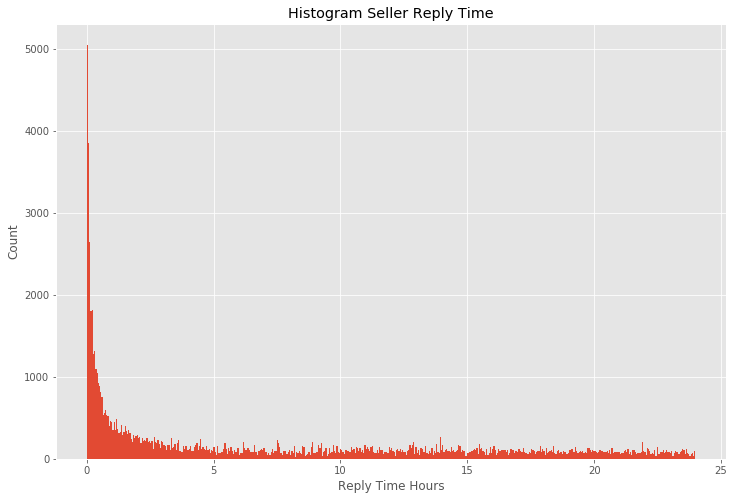

In [539]:
plt.figure(figsize=(12,8))
plt.xlabel('Reply Time Hours',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.title('Histogram Seller Reply Time')
plt.hist(reply_time_diff_hours, bins=500);